In [ ]:
# !pip install construct-tracker

In [22]:
'''
Authors: Daniel M. Low
License: See license in github repository
'''

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import json
import pickle

pd.set_option("display.max_columns", None)

import llm
# or: from construct_tracker import llm

on_colab = False

if on_colab:
  from google.colab import drive
  project_name = 'project_name'
  drive.mount('/content/drive')
  input_dir = f'/content/drive/MyDrive/datum/{project_name}/data/input/'
  output_dir = f'/content/drive/MyDrive/datum/{project_name}/data/output/'
else:
  input_dir = './data/'
  output_dir = './data/output/'

os.makedirs(output_dir, exist_ok=True)



In [23]:

def create_binary_dataset(df_metadata, dv = 'suicide', n_per_dv = 3000, dv_location = 'columns', remove_nans = True, potential_test_ids = None):
	"""
	
    Parameters
    ----------
    df_metadata : pd.DataFrame
        Dataframe containing columns for dv and text.
    dv : str
		Column or value name of dv
    n_per_dv : int
        Number of samples to take from each level of dv.
    dv_location : str
        Location of dv in df_metadata. Either 'subreddit' (or another column name containing DVs) or 'columns' (if dv is a column name).
    Returns
    -------
    df_metadata_tag : pd.DataFrame
        Binary dataset with equal number of samples in each level of dv.
    
	"""
	

	if potential_test_ids is not None:
		df_metadata = df_metadata[df_metadata['id'].isin(potential_test_ids)]

	if dv_location == 'columns':

		df_metadata_tag_1 = df_metadata[df_metadata[dv]==1].sample(n=n_per_dv,random_state=123)
		df_metadata_tag_0 = df_metadata[df_metadata[dv]==0].sample(n=n_per_dv,random_state=123)
		assert df_metadata_tag_1.shape[0] == n_per_dv
		assert df_metadata_tag_0.shape[0] == n_per_dv

		df_metadata_tag = pd.concat([df_metadata_tag_1, df_metadata_tag_0]).sample(frac=1).reset_index(drop=True)

	else:	
		if remove_nans:
			# remove nans rows 
			df_metadata = df_metadata[~df_metadata[dv_location].isna()]
			# df_metadata = df_metadata.dropna(subset=[dv_location])

		
		df_metadata_tag_1 = df_metadata[df_metadata[dv_location]==dv].sample(n=n_per_dv,random_state=123)
		df_metadata_tag_0 = df_metadata[df_metadata[dv_location]!=dv].sample(n=n_per_dv,random_state=123)
		assert df_metadata_tag_1.shape[0] == n_per_dv
		assert df_metadata_tag_0.shape[0] == n_per_dv

		df_metadata_tag = pd.concat([df_metadata_tag_1, df_metadata_tag_0]).sample(frac=1).reset_index(drop=True)
	return df_metadata_tag



In [24]:
# load pickle
with open('./data/input/reddit/reddit_13_mental_health_4600_posts_20250311_123431_dfs.pkl', 'rb') as handle:
	dfs = pickle.load(handle)

In [25]:
test_df = dfs['test']['srl_validated'].copy()
test_df = test_df[test_df['subreddit'].isin(['selfharm', 'SuicideWatch', 'bullying', 'sexualassault', 'GriefSupport', 'lonely', 'Anxiety', 'depression', 'AskLGBT', 'EatingDisorders', 'addiction'])]
df = test_df.copy()
test_df

,subreddit,id,title,author,created_utc,score,upvote_ratio,num_comments,url,is_self,selftext,sort_method,time_filter,document,word_count_x,document_id,Passive suicidal ideation,Active suicidal ideation & suicidal planning,Lethal means for suicide,Direct self-injury,Suicide exposure,Other suicidal language,Hospitalization,Loneliness & isolation,Social withdrawal,Relationship issues,Relationships & kinship,Bullying,Sexual abuse & harassment,Physical abuse & violence,Aggression & irritability,Alcohol use,Other substance use,Impulsivity,Defeat & feeling like a failure,Burdensomeness,"Shame, self-disgust, & worthlessness",Guilt,Anxiety,Panic,Entrapment & desire to escape,Trauma & PTSD,Agitation,Rumination,Depressed mood,Anhedonia & uninterested,Emotional pain & psychache,Grief & bereavement,Existential meaninglessness & purposelessness,Emptiness,Hopelessness,Perfectionism,Fatigue & tired,Sleep issues,Psychosis & schizophrenia,Bipolar Disorder,Borderline Personality Disorder,Eating disorders,Physical health issues & disability,Incarceration,Poverty & homelessness,Gender & sexual identity,Discrimination,Finances & work stress,Barriers to treatment,Mental health treatment,word_count_y
0,SuicideWatch,1ix6acg,Love of my life blocked me,Zealousideal-Cat3185,2025-02-24 11:36:10,5,1.00,0,https://www.reddit.com/r/SuicideWatch/comments...,True,I finally started to try to stand up for mysel...,top,week,Love of my life blocked me \n---\n I finally s...,123,2756,0.0,1.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,123.0
1,SuicideWatch,1it0ce3,Plz will someone talk to me?,filledeSisyphe,2025-02-19 03:00:39,4,0.84,13,https://www.reddit.com/r/SuicideWatch/comments...,True,.,top,week,Plz will someone talk to me? \n---\n .,6,2000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
2,SuicideWatch,ijs0cl,My brother killed himself and I want to be wit...,DarelMelanie,2020-08-31 01:06:55,821,1.00,36,https://www.reddit.com/r/SuicideWatch/comments...,True,Two days ago.\nWe both struggled with depressi...,top,all,My brother killed himself and I want to be wit...,62,475,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,62.0
3,SuicideWatch,1ir06tz,(16yo) I've been starving myself for days. It'...,Top_Activity4049,2025-02-16 14:24:46,69,0.95,30,https://www.reddit.com/r/SuicideWatch/comments...,True,I recently have been made fun of for my weight...,top,month,(16yo) I've been starving myself for days. It'...,96,517,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.0
4,SuicideWatch,1ith77r,i hope what happened now is just a dream if it...,cifkif,2025-02-19 16:30:27,1,1.00,1,https://www.reddit.com/r/SuicideWatch/comments...,True,it must be adream it doesnr feel real i csnr e...,new,NaN,i hope what happened now is just a dream if it...,47,2870,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7795,sexualassault,uv6m1j,was this rape/sexual assault?,NaN,2022-05-22 04:20:54,2,0.67,2,https://www.reddit.com/r/sexualassault/comment...,True,a soberish guy tried t

In [26]:
dv_tags = {
	'self_harm': 'selfharm',
 'suicide': 'SuicideWatch',
 'bully': 'bullying',
 'abuse_sexual': 'sexualassault',
 'bereavement': 'GriefSupport',
 'isolated': 'lonely',
 'anxiety': 'Anxiety',
 'depressed': 'depression',
 'gender': 'AskLGBT',
 'eating': 'EatingDisorders',
 'substance': 'addiction',
 }

# reverse 
dv_tags_reverse = {v: k for k, v in dv_tags.items()}

srl_reddit_mapping =  {
 
 'Direct self-injury': 'selfharm',
 'Active suicidal ideation & suicidal planning': 'SuicideWatch',
 'Passive suicidal ideation': 'SuicideWatch',
 'Other suicidal language': 'SuicideWatch',
 'Bullying': 'bullying',
 'Sexual abuse & harassment': 'sexualassault',
 'Grief & bereavement': 'GriefSupport',
 'Loneliness & isolation': 'lonely',
 'Anxiety': 'Anxiety',
 'Depressed mood': 'depression',
 'Gender & sexual identity': 'AskLGBT',
 'Eating disorders': 'EatingDisorders',
 'Other substance use': 'addiction',
 'Alcohol use':'addiction',

 }

construct_to_subreddit = {
    'self_harm': 'selfharm',
    'suicide': 'SuicideWatch',
    'bully': 'bullying',
    'abuse_sexual': 'sexualassault',
    'bereavement': 'GriefSupport',
    'isolated': 'lonely',
    'anxiety': 'Anxiety',
    'depressed': 'depression',
    'gender': 'AskLGBT',
    'eating': 'EatingDisorders',
    'substance': 'addiction',
}

ctl_tags11_to_srl_name_mapping = {'self_harm': ['Direct self-injury'],
 'suicide': ['Active suicidal ideation & suicidal planning',
  'Passive suicidal ideation',
  'Other suicidal language'],
 'bully': ['Bullying'],
 'abuse_sexual': ['Sexual abuse & harassment'],
 'bereavement': ['Grief & bereavement'],
 'isolated': ['Loneliness & isolation'],
 'anxiety': ['Anxiety'],
 'depressed': ['Depressed mood'],
 'gender': ['Gender & sexual identity'],
 'eating': ['Eating disorders'],
 'substance': ['Other substance use', 'Alcohol use']}

# To put inside prompt
prompt_names = {'self_harm': 'self harm or self injury',
 'suicide': 'suicidal thoughts or suicidal behaviors',
 'bully': 'bullying',
 'abuse_sexual': 'sexual abuse',
 'bereavement': 'bereavement or grief',
 'isolated': 'loneliness or social isolation',
 'anxiety': 'anxiety',
 'depressed': 'depression',
 'gender': 'gender identity',
 'eating': 'an eating disorder or body image issues',
 'substance': 'substance use'}


prompt_names_reverse = {v: k for k, v in prompt_names.items()}
prompt_names_reverse

{'self harm or self injury': 'self_harm',
 'suicidal thoughts or suicidal behaviors': 'suicide',
 'bullying': 'bully',
 'sexual abuse': 'abuse_sexual',
 'bereavement or grief': 'bereavement',
 'loneliness or social isolation': 'isolated',
 'anxiety': 'anxiety',
 'depression': 'depressed',
 'gender identity': 'gender',
 'an eating disorder or body image issues': 'eating',
 'substance use': 'substance'}

# Submit prompts to LLMs

In [27]:
try:
    import api_keys
    OPENROUTER_API_KEY = api_keys.openrouter_key 
except:
    print("Module 'api_key' not found. Add your key here. ") # get it from OpenRouter AI: https://openrouter.ai/settings/keys
    OPENROUTER_API_KEY = ""

model  = 'google/gemini-2.0-flash-001' #"gpt-4o" # "gpt-4o", "gpt-4o-mini" (cheaper), "meta-llama/llama-3.1-405b-instruct:free"   others: https://openrouter.ai/models

## Create codebook

In [28]:
from construct_tracker import lexicon
srl = lexicon.load_lexicon(name = 'srl_v1-0') # Load lexicon
srl_prototypical = lexicon.load_lexicon(name = 'srl_prototypes_v1-0') # Load lexicon
constructs_in_order = list(srl.constructs.keys())

In [29]:
# Obtain descriptions of subreddits
import praw


# You'll need to get these from your Reddit API application
CLIENT_ID = api_keys.reddit_client_id
CLIENT_SECRET = api_keys.reddit_secret
USER_AGENT = f"script:data_sampler:v1.0 (by /u/{api_keys.reddit_username})"



reddit = praw.Reddit(
    client_id=CLIENT_ID,
    client_secret=CLIENT_SECRET,
    # password="PASSWORD",
    user_agent=USER_AGENT,
    # username="USERNAME",
)


In [30]:
# Create a codebook with description of subreddit. definition of construct. and examples. 
codebook_dict = {}
for construct, subreddit in construct_to_subreddit.items():
    prompt_name = prompt_names[construct]
    srl_equivalent =  ctl_tags11_to_srl_name_mapping[construct]
    # if srl_equivalent is a list
    if type(srl_equivalent) == list:
        definitions = []
        examples = []
        for s in srl_equivalent:
            definitions.append(srl.constructs[s]['definition'])
            examples.append(srl.constructs[s]['examples'])
        srl_definition = ' '.join(definitions) # join definitions

    else:
        srl_definition = srl.constructs[srl_equivalent]['definition']    
        srl_examples = srl.constructs[srl_equivalent]['examples']    

    srl_examples = ' '.join(examples) # join examples
    srl_definition = srl_definition.replace('\n', ' ').replace('  ', ' ').replace('..', '.').replace('. .', '.').replace('...', '.').replace('..', '.')
    subreddit_object = reddit.subreddit(subreddit)  # Replace with any subreddit name


    # Access the REDDIT description
    description = subreddit_object.description
    

    print(f'\n\n{subreddit}=======================================')
    print(description)

    # You can also access the shorter public description
    public_description = subreddit_object.public_description
    print(f'\n===================')
    # print(public_description)
    codebook_dict[construct] = {
        'subreddit': subreddit,
        'prompt_name': prompt_name,
        'description': description,
        'public_description': public_description,
        'srl_equivalent': srl_equivalent,
        'srl_definition': srl_definition,
        'srl_examples': srl_examples
                                }



selfharm=======================================
A subreddit for self-harmers to relate to each other, ask questions, and build up a community. **Giving instructions on methods of self-harm is not allowed on this subreddit.**

### [**WIKI**](http://www.reddit.com/r/selfharm/wiki/index) for all kinds of resources and distractions.

[](#/RES-nightModeCompatible)[](#/RES_SR_Config/NightModeCompatible) 

##### Community Links [Community Links](http://www.reddit.com/r/selfharm)

> Our community has  a few different ways to get involved and some resources for your use. Check out the links below for more info:
>
* [Community Run Discord Chat Rooms](https://www.reddit.com/r/selfharm/comments/k62sq8/discord_links_are_back_chatrooms_are_gone_read/)  These discord chats are not run or monitored by /r/selfharm
>
* [Selfharm Wiki](http://www.reddit.com/r/selfharm/wiki/index)- rules of /r/selfharm, wound care advice, scar care tips, resources, distractions, and links to helpful subreddits.
>
* [202

In [31]:
codebook_dict = {'self_harm': {'subreddit': 'selfharm',
  'prompt_name': 'self harm or self injury',
  'description': 'A subreddit for self-harmers to relate to each other, ask questions, and build up a community. **Giving instructions on methods of self-harm is not allowed on this subreddit.**\n\n### [**WIKI**](http://www.reddit.com/r/selfharm/wiki/index) for all kinds of resources and distractions.\n\n[](#/RES-nightModeCompatible)[](#/RES_SR_Config/NightModeCompatible) \n\n##### Community Links [Community Links](http://www.reddit.com/r/selfharm)\n\n> Our community has  a few different ways to get involved and some resources for your use. Check out the links below for more info:\n>\n* [Community Run Discord Chat Rooms](https://www.reddit.com/r/selfharm/comments/k62sq8/discord_links_are_back_chatrooms_are_gone_read/)  These discord chats are not run or monitored by /r/selfharm\n>\n* [Selfharm Wiki](http://www.reddit.com/r/selfharm/wiki/index)- rules of /r/selfharm, wound care advice, scar care tips, resources, distractions, and links to helpful subreddits.\n>\n* [2022 Directory](https://www.reddit.com/r/selfharm/comments/r6nn8o/sh_directory_2022/) - Feel free to add yourself to the /r/selfharm directory!\n* [Ollie the Octopus](https://www.reddit.com/r/selfharm/comments/m2uftg/repost_octopus_coping_mechanism_please_read/) - a post from one of the mods to help with harm reduction\n>\n* Safe Disposal of [Blades](https://greenopedia.com/recycle-razor-blades/) \n>\n\n###### Rules of /r/selfharm\n>\n> \n*Appropriate content:*\n>\n- Alternatives to self-harm\n- Rants/walls of text if you just need to get something off your chest\n- DAE posts\n- Media you find encouraging or relevant (i.e. books, movies, music)\n- Poetry or original work\n- Shout-outs asking for support, a chat, etc.\n>\n*Inappropriate content:*\n>\n- Posting pictures of harm; cuts, burns, scars etc. (The exception to this is cover-up tattoos and the like)\n- Giving medical advice without supplying references (*from reliable sources or medical experience*)\n- Instructing on methods of selfharm ("How do I cut")\n- Encouragement of self harm\n- Methods for suicide\n- Suicide notes or threats\n- Demeaning or triggering comments or posts (*Hint: If you question whether or not it\'s offensive, it probably is.*)\n- Giving out personal information: see [the rules of reddit](http://www.reddit.com/rules)\n- **No Surveys:** Due the triggering nature of surveys posted in /r/selfharm, and a recent increase in these types of posts, we will no longer be accepting these submissions (whether they are ethically approved or not). We apologize for any inconvenience this may cause\n- Glorifying self harm\n>\n**Trigger warnings are no longer necessary (but will be used in extreme cases). Please take care when browsing this subreddit.**\n\n#### Related subreddits\n>\n> \n\n>\n* /r/suicidewatch\n>\n* /r/StopSelfHarm \n>\n* /r/AdultSelfHarm \n>\n* /r/arttocope\n>\n* /r/depression\n>\n* /r/mentalhealth\n>\n* /r/offmychest\n>\n* /r/vent\n>\n* /r/eatingdisorders\n>\n* /r/ADHD\n>\n* /r/Anger\n>\n* /r/anxiety\n>\n* /r/aspergers\n>\n* /r/bipolar2 \n>\n* /r/BipolarReddit\n>\n* /r/DPDR\n>\n* /r/OCD\n>\n* /r/PTSD\n>\n* /r/schizophrenia\n>\n* /r/BPD',
  'public_description': 'A subreddit for self-harmers to relate to each other, ask questions, and build up a community.',
  'srl_equivalent': ['Direct self-injury'],
  'srl_definition': 'Mention of actual or desired direct and deliberate destruction by an individual of their own body tissue, including with suicidal intent (suicidal self-injury) our without suicidal intent (non-suicidal self-injury)',
  'srl_examples': 'self-injury; cut myself; cutting; burn myself; harm myself'},
 'suicide': {'subreddit': 'SuicideWatch',
  'prompt_name': 'suicidal thoughts or suicidal behaviors',
  'description': '######[If you see abuse, trolling, or guideline violations, click here to message us! ](https://www.reddit.com/message/compose?to=%2Fr%2FSuicideWatch) ######\n    \n******   \n\n\n#Resources#\n\nThe SW Mod team also maintains **/r/SWResources**.  \n\nIf you need **help for yourself**, we\'ve got **[a directory of voice and chat/text hotline services](http://www.reddit.com/r/SuicideWatch/wiki/hotlines)** and  **[FAQs about hotlines](https://www.reddit.com/r/SuicideWatch/wiki/hotline_faqs)**, plus **[selected online resources](http://www.reddit.com/r/SuicideWatch/wiki/self_help_resources)**.  \n\nIf you\'re **concerned about someone else**, you\'re welcome to post, also check out our **[talking tips](https://www.reddit.com/r/SuicideWatch/wiki/talking_tips)** and **[risk assessment guide](http://redd.it/1c7nqf)**.  If you\'re new here and want to help, please read these two posts before diving in.   \n\nIf you\'ve **lost someone** to suicide, /r/SuicideBereavement is there for you, or you can check out **[our shared list of bereavement resources](https://www.reddit.com/r/SuicideBereavement/wiki/online_resources)**.\n\n#Guidelines#\n\n1.  **This is a place of support.**  All the following ways of responding to at-risk OPs are strictly forbidden. If you see anything like this in a post or comment, please [message the moderators](http://www.reddit.com/message/compose?to=%2Fr%2FSuicideWatch).      \n     * **Abuse or "tough love"** ***including any guilt-tripping like ["suicide is selfish"](https://speakingofsuicide.com/2015/10/28/is-it-selfish/) or "think of your loved ones"***.      \n     * **Pro-Suicide Posts or Comments,** ***or any explicit discussion of suicide methods.***  **Our policy about incitement is strict. [Please read this wiki before responding](https://www.reddit.com/r/SuicideWatch/wiki/incitement).**\n     * **Religious proselytizing**  \n     * **Trolling or incitement to suicide or any type of self-harm or violence**    \n     * **Anything that\'s not a direct, personal, supportive response to the OP.**\n\n1.  **Please note that we are NOT a hotline!** We do NOT have the ability to trace the source of any posts, and we can\'t guarantee immediate responses. \n\n1.  **We offer non-judgemental peer support ONLY.**  The only requirement to respond here is genuine concern, so please don\'t take anything you read here as professional advice. It\'s fine to share what worked for you, but **DO NOT advocate for or against any specific type of therapy, self-help strategy, or medication, especially street drugs or alcohol, and DO NOT diagnose people** \n\n1.  **If you\'re here to help please respond** ***publicly*** **to our OPs in need.**  Sort by "new" and check for posts with few or no good responses.  The rules below link to posts with details.     \n     * [Posts shouldn\'t include or request contact information.](http://redd.it/dmu24)  \n     * [Don\'t "advertise" yourself as a helper, authority, or role model.  This includes inviting private contact as a first resort.](http://redd.it/xgrba)\n     * [Do NOT post general "uplifting" or anti-suicide messages. Encouragement should never be offered until you\'ve demonstrated understanding of the OP\'s emotions and experience, to ***their*** satisfaction, not yours! This also means no fundraising or activism, please.](http://redd.it/1cep2h) \n     * [Please, **never make promises to our vulnerable OPs that you personally can\'t keep**.  This means ***not*** saying "it gets better" or guaranteeing any outcomes!  It also means not to make any "supportive" but unverifiable assertions about the OP, i.e. telling them they\'re a good/strong/etc. person.](http://redd.it/25igd7)\n\n1.  **We err on the side of safety**. If we need to remove a post or comment from someone who\'s reached out for help, we\'ll let them know why we removed it and how they can change it.  If this happens to you, please know that we **do** want to talk to you.  \n\n1.  **If you need help but don\'t feel comfortable making a post** for any reason, please [**message the moderators**](http://www.reddit.com/message/compose?to=%2Fr%2FSuicideWatch).  We will be glad to talk with you privately, or help in any other way that we can.\n\n1.  Surveys and research participation requests ***must*** be pre-approved by the mod team. Posts we have okayed will be flaired.\n\n1. Anything that\'s primarily of philosophical or scientific interest does not belong here.',
  'public_description': 'Peer support for anyone struggling with suicidal thoughts.',
  'srl_equivalent': ['Active suicidal ideation & suicidal planning',
   'Passive suicidal ideation',
   'Other suicidal language'],
  'srl_definition': "Explicit suicidal thoughts of killing oneself; mention of methods, plan, preparations, time, and/or place of suicide attempt. Suicidal thoughts desiring one's own death or related states (e.g., disappearing, not waking up). Suicidal language that does not belong in the other suicidal categories (active and passive SI, self-injury, and lethal means for suicide)",
  'srl_examples': "kill myself; jump off a bridge; jump in front of a train; overdose; hang myself; shoot myself wish I wasn't alive; wish I could disappear; hoping I wouldn't wake up; I want to die no reason to live; safety plan; I hate my life"},
 'bully': {'subreddit': 'bullying',
  'prompt_name': 'bullying',
  'description': '#BEFORE YOU POST...\n\nPlease [FOLLOW THE RULES OF THE **REDDIQUETTE**] (https://www.reddithelp.com/hc/en-us/articles/205926439/) when posting to /r/bullying. **YOU WILL BE PERMABANNED IF YOU BREAK ANY RULES. NO WARNINGS.**\n\n\n**NO POSTING PERSONAL INFORMATION.** This includes names, phone numbers, usernames, e-mail & physical addresses, schools, workplaces, unwarranted photos or recordings of people, etc. Your post will be deleted if it does contain any of this without approval before the time of posting. \n\n\nThis is a subreddit intended to be a safe discussion board for people of any and all backgrounds **wishing to help others or simply converse** about issues, ideas, and discussions related to bullying (online/cyber or not). Oppressive or offensive attitudes/language will not be tolerated. **Do not post here if you are looking for help in bullying others.**\n\n#What is bullying?\n\nBullying is a repeated aggressive behavior where one person (or group of people) in a position of power deliberately intimidates, abuses, or coerces an individual with the intention to hurt that person physically or emotionally. This can apply to online activities as well.\n\n#Related communities <3\n\n/r/cyberbullying\n\n/r/offmychest\n/r/depression\n/r/suicidewatch\n/r/stopselfharm\n/r/anger\n/r/anxiety\n/r/depression \n\n/r/getmotivated\n/r/casualconversation\n/r/eyebleach\n/r/happy\n\n#Post not showing up? \n\n[Message the moderators](http://www.reddit.com/message/compose?to=%2Fr%2Fbullying) with your post title or link and it will be approved.',
  'public_description': 'We are the community dedicated to anti-bullying. Share your story or get involved to help others and make positive change. 🤝',
  'srl_equivalent': ['Bullying'],
  'srl_definition': 'Bullying is defined as intentional, repeated, and harmful aggressive behavior (verbal, physical, social) often with an imbalance of power between the perpetrators and the victims.',
  'srl_examples': 'bullied; makes fun of me'},
 'abuse_sexual': {'subreddit': 'sexualassault',
  'prompt_name': 'sexual abuse',
  'description': 'sexualassault',
  'public_description': 'This is a support subreddit for survivors of all forms of sexual assault. Please read the rules before posting and commenting! TURN OFF YOUR PMs!',
  'srl_equivalent': ['Sexual abuse & harassment'],
  'srl_definition': 'Any non-consensual act or behavior of a sexual nature imposed on someone. It can range from unwanted sexual touching and coercion to rape and exploitation. We also include sexual harassment in this lexicon. ',
  'srl_examples': 'rape; sexual assault; was abused; non-consensual; molested me; stalking; groped me'},
 'bereavement': {'subreddit': 'GriefSupport',
  'prompt_name': 'bereavement or grief',
  'description': '**"Learning to Live Without"**\n\nA place to share stories, ask questions or seek advice. Grief affects every person in a different way every time. Whether you are grieving the dead, a relationship, a job, a pet, a place or an era you are welcome here.\n\n\n&nbsp;\n\n**For Immediate Help**\n\n[Suicide Hotline Numbers](https://www.reddit.com/r/SuicideWatch/wiki/hotlines)\n\n[Substance Abuse Helpline (US)]( https://www.samhsa.gov/find-help/national-helpline)\n\nr/SuicideWatch\n\nr/SWResources\n&nbsp;\n\n**Chat with Us**\n\nWe use Discord as our main method of chat as its easy to get into from any device, with no login required.  People may not be chatting at all hours, but it\'s a quick way to be heard, or just hang out.\n\nPlease post as often as necessary.  Let your fingers fly.  There are no right or wrong answers in this, just experiences.  Don\'t hesitate to write us a wall of text.\n\n* [#GriefSupport](https://discord.gg/VGmYmsVAqy)\n\n\n&nbsp;\n\n**Grief Resources**\n\nCheck out our [wiki](https://www.reddit.com/r/GriefSupport/wiki/index) for additional resources and support.\n\n&nbsp;\n\n**Supportive Friends**\n\nr/AddictionGrief\n\nr/askfuneraldirectors\n\nr/Assistance\n\nr/babyloss\n\nr/bereavement\n\nr/cancer\n\nr/cancergrief\n\nr/CaregiverSupport\n\nr/CatAngels\n\nr/charity\n\nr/ChildrenofDeadParents\n\nr/CPTSD\n\nr/COVIDgrief\n\nr/DadForAMinute\n\nr/death\n\nr/depression\n\nr/Divorce\n\nr/EctopicSupportGroup\n\nr/FathersofLoss\n\nr/gaminggriefsupport\n\nr/gofundme\n\nr/grief\n\nr/Grieving\n\nr/GrievingParents\n\nr/grievinggrandparents\n\nr/Healingaftersuicide\n\nr/InMemoryOf\n\nr/lastimages\n\nr/lossofachild\n\nr/LostaLovedOne\n\nr/Miscarriage\n\nr/MomForAMinute\n\nr/motherlessdaughters\n\nr/opiatesmemorial\n\nr/overdoseGrief\n\nr/PetLoss\n\nr/ptsd\n\nr/Rainbow_Babies\n\nr/SuicideBereavement\n\nr/SuicideWatch\n\nr/SWResources\n\nr/thefallen\n\nr/ttcafterloss\n\nr/TwinlessTwins\n\nr/Waldenstroms\n\nr/widowers',
  'public_description': 'A place to share stories, ask questions or seek advice. Grief affects every person in a different way every time. Whether you are grieving the dead, a relationship, a job, a pet, a place or an era you are welcome here.',
  'srl_equivalent': ['Grief & bereavement'],
  'srl_definition': 'Sadness from losing a loved one (grief) which may result in depressive symptoms (bereavement). This may also include losing a relationship or the health of a loved one. ',
  'srl_examples': 'grief; grieving;  bereavement; bereaving;  divorce; breakup; died; passed away'},
 'isolated': {'subreddit': 'lonely',
  'prompt_name': 'loneliness or social isolation',
  'description': 'A community for all the lonely people. Everyone is welcome here, no matter your age, race, sex, sexuality, relationship status. All that we request is that you be accepting of people, and kind. Any problems at all, please [let the moderators know.](https://reddit.com/message/compose?to=/r/lonely)\n\n****\n\nIf you prefer realtime interaction, you might want to check out our **[Discord server!](https://discord.gg/MhdCcDg)**\n\n***\n\n=================================\n\n**Similar communities**\n\n* /r/Needafriend \n* /r/ForeverAlone\n* /r/MeetPeople  \n* /r/MakeNewFriendsHere\n* /r/Breakups\n* /r/HeartBreak\n* /r/MentalHealth\n* /r/Sad\n* /r/Depression\n\n\n\n****\n\n\n\n\n#Rules:\n\n###**Rule 1: No discrimination, sexism or racism**\n* Pretty self explanatory this one, no discriminating based on a person\'s circumstances, this is a tolerant community and anyone found breaking these rules will be dealt with.\n\n###**Rule 2: Please be kind**\n* This isn\'t so much as a rule, but just worth remembering. Most of us here are quite vulnerable, so please just if you can, spare a kind word, and if not, at the very least don\'t try and make someone feel worse. \n\n###**Rule 3: No suicide encouragement, glorification, or notes**\n* Also goes without saying, don\'t tell people to kill themselves, don\'t glorify suicide/death, and, unfortunately, we will have to remove any suicide notes from here, as whilst we want to help everyone, we do not want more people getting that idea.\n\n###**Rule 4: Don\'t post personal information outside of PM\'s**\n* For your own safety, do not post or comment your phone number, social media usernames etc. outside of private messages.\n\n###**Rule 5: No NSFW or posts looking for a relationship**\n* r/r4r might be more suited for that.. If someone ends up PM\'ing you only for the purpose of getting nudes, etc. Instead of making a post "exposing" them, Send a message to the moderators so we can take action.\n\n###**Rule 6: Don\'t spam, advertise or push your religion upon others**\n* Your post/comment will be removed, and action might be taken.\n\n###**Rule 7: Trigger warnings**\n\n* Please apply proper trigger warning post flairs on posts talking about suicide, abuse or drugs.',
  'public_description': 'A community for all the lonely people. Everyone is welcome here, no matter your age, race, sex, sexuality, relationship status. All that we request is that you be accepting of people, and kind. Any problems at all, please let the moderators know.',
  'srl_equivalent': ['Loneliness & isolation'],
  'srl_definition': "Loneliness: aversive state experienced when a discrepancy exists between the interpersonal relationships one wishes to have and those that one perceives they currently have. The perception that one's social relationships are not living up to some expectation (Heinrich & Gullone 2006). Isolation: the expression of solitary behavior that results from peer rejection (Rubin & burgess). Related to thwarted belongingness where the person perceives loneliness, isolation, and a failing to meet one's need to belong (Van Orden et al 2010).",
  'srl_examples': 'lonely; isolated'},
 'anxiety': {'subreddit': 'Anxiety',
  'prompt_name': 'anxiety',
  'description': '##### [](https://discord.gg/9sSCSe9)\n\n# [IF YOU\'RE IN CRISIS, CLICK HERE](https://www.reddit.com/r/Anxiety/wiki/ineedhelp)\n\n###### Want to chat with other awesome anxious users? Check out our [Discord Chat] (https://discord.com/invite/9sSCSe9)\n\n\n#Useful wiki pages\n[Check out this page for immediate help for panic.](/r/anxiety/w/onlineresources/)   \n\n[Seeking Professional Help?](https://www.reddit.com/r/anxiety/w/gettinghelp) - information on where to turn and what to do once you\'ve decided you want to get help.\n\n#Rules & Guidelines\n**Ground Rules**   \n\n* All posts must be related to anxiety.   \n* Follow Reddiquette at all times.\n* No memes. We\'d appreciate it if those were posted to our sister sub, /r/anxietymemes.\n\n\n**Be Supportive**   \n\n* We are a supportive community. Please comment positively and treat others with respect. You are free to disagree, but do so politely. We are here to support each other, not tear each other apart.\n* Be mindful of common triggers.\n\n**Medical Discussions**\n\n* We are not medical professionals and cannot diagnose you or give you medical advice.\n* No discussions of where to buy or how to obtain medications or drugs. This includes benzos and CBD. If it is a drug you can purchase without a prescription, no discussion regarding specific brands or dosages.\n* Do not promote "quick fix" products or ideas. \n\n**Grandstanding**\n\n* This is not the place to promote an ideology or political views. While everyone is entitled to their beliefs, we will not accept attempts to pressure others or hijack the subreddit\'s conversation.\n* r/Anxiety attempts to be politically neutral, and we expect our users to respect that. Threads about politics should remain focused on the anxiety, not the politics.\n\n**Self-Promotion**   \n\n* This is not a venue to promote your blog or vlog, feel free to share those on /r/AnxietyBlogs.\n* Do not advertise products or services.\n* Messaging users without their consent will get you banned.\n\n**Research Studies/Surveys**   \n\n* We request to review all research studies before they are posted. Please see the details [here](https://www.reddit.com/r/Anxiety/wiki/rules).\n\n---\n\n**Check out the wiki [here](/r/Anxiety/wiki/)**\n\n---   \n\n>#\n\nRotating List||\n:--|:--\n/r/SuicideWatch  |  /r/Needafriend | \n/r/CPTSD  | /r/namelessfriends | \n/r/dpdr | /r/howtonotgiveafuck | \n/r/MeetNewPeopleHere | /r/selfhelp| \n/r/socialanxiety | /r/ExplainLikeImScared| \n\n\n[Full List Located Here](www.reddit.com/r/Anxiety/wiki/relatedsubreddits)',
  'public_description': 'Discussion and support for sufferers and loved ones with anxiety conditions. Please look over the rules before posting to the subreddit.\n',
  'srl_equivalent': ['Anxiety'],
  'srl_definition': 'Anxiety is a feeling of worry, nervousness, or unease, often about an imminent event or something with an uncertain outcome. We include anxiety disorders.',
  'srl_examples': 'anxiety; fear; afraid; worried; OCD; PTSD; panic attacks; social anxiety; phobia; nightmare; nervous'},
 'depressed': {'subreddit': 'depression',
  'prompt_name': 'depression',
  'description': '###Community Basics\n\nWe offer a [peer-support](https://www.reddit.com/r/depression/wiki/giving_help) space for anyone dealing with a depressive disorder in themselves or someone close to them.\n\n[Please stay on topic](https://www.reddit.com/r/depression/wiki/what_is_depression). Depression is both important and difficult to talk about so focus is essential. Posts here need to be support requests specifically related to depression, and comments need to be supportive of the OP.\n\nIf you want to talk about thoughts or risk of suicide, please post at /r/SuicideWatch. If you\'ve lost someone to suicide, /r/SuicideBereavement is the best community to get support.\n\nIt might seem that we have a lot of rules, but we\'ve found they\'re all necessary to maintain as much emotional and physical safety as possible. Most people are surprised by at least some of our policies so please [read all of them carefully](https://www.reddit.com/r/depression/about/rules) before jumping in.\n\nPlease click "report" to let us know of any inappropriate content you see here - we\'d like to know and handle it as soon as we can.\n\nIf your post or comment is not appearing, it may have been removed for a rule violation or it may be stuck in the filter. Please message us and we\'ll look into it.\n\nWe are not a crisis service. We can\'t guarantee an immediate response, and there are times when this subreddit is relatively quiet. This does not mean no one cares. If you need to talk to someone at once, you may want to [take a look at the hotlines list from /r/SuicideWatch](http://www.reddit.com/r/SuicideWatch/wiki/hotlines)',
  'public_description': 'Peer support for anyone struggling with a depressive disorder',
  'srl_equivalent': ['Depressed mood'],
  'srl_definition': 'Low mood and sadness that does not go away after a few weeks',
  'srl_examples': 'depression; sadness; low mood; melancholy'},
 'gender': {'subreddit': 'asktransgender',
  'prompt_name': 'gender identity',
  'description': '#Welcome!\nQuestions and discussions about, for, to, or from the Reddit transgender community. \n\n*Open to anyone with a question.*\n\n---\n\n#[Rules](/r/asktransgender/wiki/rules):  \n\n#####1. Your post should be relevant, inclusive, and encourage discussion.\n\n* Titles should be in the form of a question; if this is not possible, make sure the post title or content provides a starting point for discussion. \n* Posts that *can* be applied broadly *must* be applied broadly.\n * Don\'t ask things specifically of a given group if the question is applicable outside that group.\n * Use inclusive language, e.g. not "How did you ladies choose a female name?" but instead "How did you find your new name?"\n* Image submissions are disabled. Do not link through to images.\n\n##### 2. Be respectful. \nNo:\n\n* bigotry (transphobia, homophobia, sexism, racism, etc) or [gendered slurs](/r/asktransgender/wiki/genderedslurs),\n* hateful speech or disrespectful commentary,\n* personal attacks,\n* [invalidation](/r/asktransgender/wiki/invalidation), [gender policing](/r/asktransgender/wiki/genderpolicing), or shaming based on stealth, open or closeted status.\n\n##### 3. No trolling or personal agendas. \nPosts and comments made with such ulterior motives are not allowed.\n\n##### 4. No stirring the pot. \n* Do not post threads that intentionally create drama or encourage witch-hunting.\n* Do not post threads about ongoing drama elsewhere (on other subreddits, on other websites, in the news, etc.) - political discussion is expected and permitted.\n* Do not target other subreddits, link to threads in other subreddits, or otherwise encourage brigading.\n\n#####5. Minors **under the age of 13** are not allowed on Reddit. \n> [Although we welcome users from all walks of life, Reddit is not aimed at children, and the United States government has put limits on our ability to accept users under a certain age through the Children\'s Online Privacy Protection Act of 1998. Individuals under the age of 13 may not create an account with us. If you believe someone 12 or younger is using our site without parental consent, please contact us.](https://www.reddit.com/wiki/privacypolicy#wiki_children_under_13)\n\n##### 6.  [Get mod approval](http://www.reddit.com/message/compose?to=%2Fr%2Fasktransgender) before posting a questionnaire, survey, promotion, or advertisement. \n\n* Please review [our guidelines](https://www.reddit.com/r/asktransgender/wiki/rule6) for these types of post. \n\n* We do not allow fundraising posts/requests under any circumstances.\n\n##### 7. Mark NSFW posts. \nPosts that center around genitals, breasts, sex, or content you would not discuss with coworkers, your grandmother, or other delicate company should be marked as NSFW.\n\n##### 8. No fetishization or chasers. \n\n* We will remove any posts treating trans bodies as fetishes or objects, and any posts that indicate your attraction is more important than your partner\'s dysphoria.\n\n* Do not ask how to meet trans people. This is not a dating subreddit. \n\n---\n\n#Useful Links:\n\n#####[Suicide Hotlines](https://www.reddit.com/r/asktransgender/wiki/suicide_resources)  \n#####[US Informed Consent Clinics](https://www.reddit.com/r/asktransgender/comments/d6p05q/i_compiled_every_single_informed_consent_clinic/)  \n\n#####[Wiki](/r/asktransgender/wiki) | [Glossary](http://www.reddit.com/r/asktransgender/wiki/glossary) | [FAQ](http://www.reddit.com/r/asktransgender/wiki/faq) | [Related Subreddits](http://www.reddit.com/r/asktransgender/wiki/linked) | [Sticky Archive](https://www.reddit.com/r/asktransgender/wiki/stickyarchive)\n\n---\n\n#Medical Disclaimer:\nThe members of this subreddit do not act as medical professionals. We only provide general information about medical transition, which may be unsuited to your individual circumstances. This information is not intended nor recommended as a substitute for medical advice. Always seek the advice of a qualified health care provider regarding any medical questions.',
  'public_description': 'Questions and discussions about, for, to, or from the Reddit transgender community.\n\nOpen to anyone with a question.',
  'srl_equivalent': ['Gender & sexual identity'],
  'srl_definition': "Gender identity refers to an individual's sense of their self as male, female, transgender, non-binary, genderfluid, agender, or something else. Gender identity is distinct from the cultural roles, behaviors, and attributes expected of women and men based on their sex assigned at birth. Sexual identity, also known as sexual orientation, refers to the pattern of romantic or sexual attraction to others. Common sexual identities include: heterosexual, homosexual, bisexual, pansexual, and asexual.",
  'srl_examples': 'gay; heterosexual; homosexual; lesbian; pansexual; bisexual; asexual; male; female; nonbinary; transgender; intersex; questioning'},
 'eating': {'subreddit': 'EatingDisorders',
  'prompt_name': 'an eating disorder or body image issues',
  'description': '## For Awareness, Information, and Questions about Recovering from EDs. We are a pro-recovery site and only allow approved posts. All Redditors can reply to posts.\n\n* **[Hunger Hormones](http://www.reddit.com/r/EatingDisorders/comments/2f0p7y/anorexia_to_binging_its_not_about_will_power_its/)** May help you understand your difficulty.\n\n* **This site** allows only posts approved by the moderators to help keep it safe for everyone recovering. We approve most requests sent in, though please read the rules. All Redditors can reply.\n\n* **We are for  *QUESTIONS* about EDs** for yourself or a loved one.\n\n* **Consider the Search Reddit** bar and limit your search to /r/eatingdisorders. Answers abound.\n\n* **Please No Numbers** about weight, bmi, clothing size, extreme details, or caloric intake. Saying you are a healthy weight, overweight, or underweight is enough.\n\n* **We will not post links to personal blogs, product/service advertisements, and most non-academic projects.** Research institutes looking for surveys or study participants may apply through modmail.\n\n* **Report pro-ED comments.** Click on "report" under the comment to notify the moderators, or send us a message.\n\n----\n\n**ED Information, Organizations, Help** \n\n * [National Eating Disorders Assoc](https://www.nationaleatingdisorders.org/)\n\n * [ANAD](http://www.anad.org/)\n\n * [Nat. Assoc. for Males with EDs](http://www.namedinc.org/)\n\n * [Eating Disorders Anonymous](http://www.eatingdisordersanonymous.org/index.html)\n\n * [National Eating Disorders Information Centre - Canada](http://nedic.ca/)\n\n * [NEDA Phone and Chat support](https://www.nationaleatingdisorders.org/find-help-support)\n\n * [PBS NOVA - Dying to be Thin](http://www.pbs.org/wgbh/nova/body/dying-to-be-thin.html)\n\n * [Possible Causes of Eating Disorders](http://www.pbs.org/perfectillusions/eatingdisorders/preventing_causes.html)\n\n * [Gurze Books](http://www.bulimia.com)\n\n * [Negotiate the 2012 Holidays Link](http://www.reddit.com/r/EatingDisorders/comments/148ipq/twelve_ideas_to_help_people_with_eating_disorders/)\n\n * [Helping a Friend, Partner, or Child with an ED](http://www.b-eat.co.uk/about-eating-disorders/leaflet-library)\n\n * [What Should I Do? Guidelines for Friends and Loved Ones](http://www.mediafire.com/view/1u2yzh1tm1z9ew4/Guidelines+for+Helping+a+Loved+One.pdf)\n\n----\n\n**Some self-help, or for use with a therapist.**\n\n * [Start Accepting Your Body at Any Size](http://www.webmd.com/healthy-beauty/features/accepting-your-body-at-any-size?print=true)\n\n * [Mindfulness process RAIN](https://sites.google.com/site/psychospiritualtools/Home/meditation-practices/using-rain)\n\n * [The Work of BK](http://www.thework.com/thework-4questions.php) \n\n\n\n----\n**Reddits of interest**\n\n* [ED Recovery](http://www.reddit.com/r/EDrecovery/)--\n\n* [Body Acceptance](http://www.reddit.com/r/BodyAcceptance/)\n\n* [Dialectical Behavior Therapy Self-Help](http://www.reddit.com/r/dbtselfhelp/)\n\n* [Food Addiction](http://www.reddit.com/r/FoodAddiction)\n\n* [Mental Health](http://www.reddit.com/r/mentalhealth)\n\n* [Off My Chest](http://www.reddit.com/r/offmychest/) -Just write your story\n\n* [Self Help](http://www.reddit.com/r/selfhelp)\n\n* [Avoidant/Restrictive Food Intake Disorder](http://www.reddit.com/r/arfid) like Selective Eating Disorder, SED\n\n* [Stop Self Harm](http://www.reddit.com/r/stopselfharm)\n\n* [Body Dysmorphic Disorder](http://www.reddit.com/r/DysmorphicDisorder)\n\n----\n\n**Abbreviations**\n\n* AN: anorexia nervosa\n\n* ARFID: Avoidant/restrictive food intake disorder\n\n* BED: binge eating disorder\n\n* BN: bulimia nervosa\n\n* ED: eating disorder\n\n* EDNOS: eating disorder not otherwise specified\n\n* Avoid abbreviations such as "ana" or "mia".\n\n* TW: trigger warning',
  'public_description': "r/EatingDisorders is a community dedicated to providing support, resources, and encouragement for individuals dealing with eating disorders. Whether you're in recovery, supporting a loved one, or seeking information, this subreddit is a supportive space with the aim to provide you with the support you need.",
  'srl_equivalent': ['Eating disorders'],
  'srl_definition': 'Eating disorders are mental health conditions characterized by unhealthy and obsessive behaviors related to food, eating, and body image. Common types include anorexia nervosa, bulimia nervosa, and binge-eating disorder.',
  'srl_examples': 'anorexia; bulimia; binge; purging; eating disorder'},
 'substance': {'subreddit': 'addiction',
  'prompt_name': 'substance use',
  'description': 'A place to discuss addiction. Get inspired, educated and guided to manage your addiction!\n\n---\n\n**Rules:**\n**1. Be supportive and respectful** Please offer advice, assistance, or contribute in a positive way and treat others with kindness and consideration. No derogatory or insulting comments, hate speech, or discrimination will be tolerated.\n\n**2. Respect privacy and anonymity** Do not share personal information without permission. This includes real names, phone numbers, addresses, and social media accounts.\n\n**3. Surveys & research studies** Surveys & research requests must be approved by the mod team via modmail. Posts that have been approved will be flaired.\n\n**4. No advertising of goods and services** In keeping with the focus of our community on addiction and recovery, we ask that members refrain from sourcing, selling or advertising goods and services, including but not limited to telegram and other social media services. Private messaging other members for these purposes is not okay and may result in a ban.\n\n**5. Promote safety and well-being** Encouraging or promoting self-harm or suicide is not allowed.\n\n**6. Use proper warnings for triggering content** If you feel your post contains graphic or potentially triggering content and would like to give others a heads up, please use the “Trigger Warning" Flair.\n\n**7. Share approved addiction recovery resources** You are welcome to share trusted addiction recovery resources, but please keep in mind that they will need to be manually approved by the moderators. Additionally, any promotion or solicitation of unrelated products, services, or websites must also receive approval.\n\n**8. Give constructive advice**\nRemember that all advice given is from peers and not professional counselors or therapists. Provide constructive advice and avoid criticizing or attacking the OP.\n\n---\n\n**Resources**\n\n[**Global Suicide Hotline**](https://www.reddit.com/r/addiction/wiki/resources/global-suicide-hotlines/)\n\n[**Recovery Services**](https://www.reddit.com/r/addiction/wiki/resources/recovery-services/)\n\n[**Discord Server**](https://discord.com/invite/qYfxpTV6x5)\n\n---',
  'public_description': 'A place to discuss addiction. Get inspired, educated and guided to manage your addiction!',
  'srl_equivalent': ['Other substance use', 'Alcohol use'],
  'srl_definition': 'Mentions of types of abused substances and related behaviors (snort), measures (8 ball), and states (high, buzz) Mentions of types of alcohol beverages and related behaviors (drinking), measures (shot), and states (drunk)',
  'srl_examples': 'cocaine; heroin; weed; cannabis; meth; amphetamine; snort; 8 ball; pain killer; opioid beer; cocktail; wine; hangover; drunk; buzz'}}

In [32]:
# use just SRL definition and examples. 


def create_codebook_string(codebook_dict, with_examples = True, randomize=False):
    """Create codebook string from dictionary, optionally randomizing construct order.
    
    Args:
        codebook_dict (dict): Dictionary containing construct definitions
        randomize (bool): Whether to randomize order of constructs
        
    Returns:
        str: Formatted codebook string
    """
    import random
    
    # Get list of constructs
    constructs = list(codebook_dict.keys())
    
    # Randomize order if specified
    if randomize:
        random.shuffle(constructs)
        
    # Build codebook string
    codebook_string = """"""
    for construct in constructs:
        prompt_name = codebook_dict[construct]['prompt_name']
        if with_examples: 
            construct_str = f"{prompt_name.capitalize()}: {codebook_dict[construct]['srl_definition']}. Examples: {codebook_dict[construct]['srl_examples']}".replace('\n', ' ').replace('  ', ' ').replace('..', '.').replace('. .', '.').replace('...', '.').replace('..', '.')

        else:
            construct_str = f"{prompt_name.capitalize()}: {codebook_dict[construct]['srl_definition']}.".replace('\n', ' ').replace('  ', ' ').replace('..', '.').replace('. .', '.').replace('...', '.').replace('..', '.')

        codebook_string += construct_str + '\n\n'
        
    return codebook_string

codebook_string = """"""

for construct in codebook_dict:
    prompt_name = codebook_dict[construct]['prompt_name']
    
    construct_str = f"{prompt_name.capitalize()}: {codebook_dict[construct]['srl_definition']}. Examples: {codebook_dict[construct]['srl_examples']}".replace('\n', ' ').replace('  ', ' ').replace('..', '.').replace('. .', '.').replace('...', '.').replace('..', '.')
    codebook_string += construct_str+'\n\n'

print(codebook_string)

Self harm or self injury: Mention of actual or desired direct and deliberate destruction by an individual of their own body tissue, including with suicidal intent (suicidal self-injury) our without suicidal intent (non-suicidal self-injury). Examples: self-injury; cut myself; cutting; burn myself; harm myself

Suicidal thoughts or suicidal behaviors: Explicit suicidal thoughts of killing oneself; mention of methods, plan, preparations, time, and/or place of suicide attempt. Suicidal thoughts desiring one's own death or related states (e.g., disappearing, not waking up). Suicidal language that does not belong in the other suicidal categories (active and passive SI, self-injury, and lethal means for suicide). Examples: kill myself; jump off a bridge; jump in front of a train; overdose; hang myself; shoot myself wish I wasn't alive; wish I could disappear; hoping I wouldn't wake up; I want to die no reason to live; safety plan; I hate my life

Bullying: Bullying is defined as intentional,

In [33]:
prompt_template = """In the following Reddit post, classify the following constructs, defined as follows:\n\n{codebook_string}

Provide a probability score between 0 and 1 for each construct (0=construct is not mentioned, indirectly mentioned, or not clear, 1 = clear and prototypical mention of the construct) as to whether the text clearly mentions the construct and an explanation (words or phrases from the text that are very prototypical expressions of the construct). Only provide a score for these constructs.

Post: 

{text}

Structure your response in the following JSON format (no extra text):
{{'construct_A': [[score], [words, phrases]], 'construct_B': [[score], [words, phrases]], ...}}

JSON:
"""

# Insert into prompt
prompt = prompt_template.format(
              codebook_string = codebook_string,
              text= "No one cares about me. I go to therapy, but I'm lonely"
              )


print('True label:', 'lonely')
print('Prompt:')
print(prompt)


True label: lonely
Prompt:
In the following Reddit post, classify the following constructs, defined as follows:

Self harm or self injury: Mention of actual or desired direct and deliberate destruction by an individual of their own body tissue, including with suicidal intent (suicidal self-injury) our without suicidal intent (non-suicidal self-injury). Examples: self-injury; cut myself; cutting; burn myself; harm myself

Suicidal thoughts or suicidal behaviors: Explicit suicidal thoughts of killing oneself; mention of methods, plan, preparations, time, and/or place of suicide attempt. Suicidal thoughts desiring one's own death or related states (e.g., disappearing, not waking up). Suicidal language that does not belong in the other suicidal categories (active and passive SI, self-injury, and lethal means for suicide). Examples: kill myself; jump off a bridge; jump in front of a train; overdose; hang myself; shoot myself wish I wasn't alive; wish I could disappear; hoping I wouldn't wak

In [34]:
def loop_through_documents(prompt_template, codebook_dict, documents, post_ids, OPENROUTER_API_KEY, model, output_dir = './data/input/llms/', randomize=False, safety_settings = None, with_examples=True, add_to_filename = None):
    results_all = {}
    metadata_all = {}
    timestamp = datetime.datetime.utcnow().strftime('%y-%m-%dT%H-%M-%S')
    os.makedirs(output_dir, exist_ok=True)
    for i, (document, post_id) in enumerate(zip(documents, post_ids)):
        if i%5 == 0:
            print(i)
        codebook_string = create_codebook_string(codebook_dict, randomize=randomize, with_examples=with_examples)    
        prompt = prompt_template.format(
                    codebook_string = codebook_string,
                    text= document
                    )
        try: 
            final_result, metadata = llm.openrouter_request(prompt, OPENROUTER_API_KEY, model = model, temperature=0, safety_settings=safety_settings)
            results_all[post_id] = final_result
            metadata_all[post_id] = metadata
        except:
            print('WARNING: API request did not work, returning NaN for this document:', post_id)
            results_all[post_id] = np.nan
            metadata_all[post_id] = np.nan

        
        
        # print('WARNING this returned an NA: ', post_id,document)
        
        model_clean = model.replace('/', '_')
        
        if add_to_filename:
             filename = f"{model_clean}_{add_to_filename}_{timestamp}"
        else:
             filename = f"{model_clean}_{timestamp}"
             
        # Save json every 20 
        if i%20 == 0:
            with open(output_dir+f'features_final_result_{filename}.json', 'w') as f:
                json.dump(results_all, f, indent=4)
            with open(output_dir+f'features_metadata_{filename}.json', 'w') as f:
                json.dump(metadata_all, f, indent=4)

    # One last time for all the texts
    with open(output_dir+f'features_final_result_{filename}.json', 'w') as f:
                json.dump(results_all, f, indent=4)
    with open(output_dir+f'features_metadata_{filename}.json', 'w') as f:
        json.dump(metadata_all, f, indent=4)
    return results_all, metadata_all




In [35]:
# # Most commonly used: # https://openrouter.ai/models?order=top-weekly
# # Leaderboard: https://openrouter.ai/rankings/health?view=week

# models = [
#     # "google/gemini-2.0-flash-001",
#     'openai/gpt-4o',
#     # "openai/gpt-4o-mini",
#     ]

# model = models[0]

# server =  "openai"


In [36]:
500/25

20.0

In [37]:

run_this = False

if run_this:
    toy = False
    n = 970 # defualt = 0, but if it breaks, you can start from here


    if toy: 
        # df = test_df[test_df.copy()['subreddit'].isin(['selfharm', 'Anxiety'])]
        df = df.sample(n = 20, random_state = 123)



    documents = df['document'].tolist()[n:]
    labels = df['subreddit'].tolist()[n:]
    post_ids = df['id'].tolist()[n:]


    final_result, metadata = loop_through_documents(prompt_template, codebook_dict, documents, post_ids, OPENROUTER_API_KEY, model, output_dir = './data/input/llms/', 
                                                    randomize=True, add_to_filename = 'content_validity')




In [38]:
# # Open json
# model = 'google/gemini-2.0-flash-001'
# model_clean = model.replace('/', '_')
# timestamps = ['25-03-24T18-55-11', '2025-03-20_17-55-19']



# Content validity

In [39]:
safety_settings = {
    "openai": [
        {
            "category": "harm_category",
            "threshold": "block_none"
        }
    ],
    "google": [
        {
            "category": "HARM_CATEGORY_HARASSMENT",
            "threshold": "BLOCK_NONE"
        },
        {
            "category": "HARM_CATEGORY_HATE_SPEECH",
            "threshold": "BLOCK_NONE"
        },
        {
            "category": "HARM_CATEGORY_SEXUALLY_EXPLICIT",
            "threshold": "BLOCK_NONE"
        },
        {
            "category": "HARM_CATEGORY_DANGEROUS_CONTENT",
            "threshold": "BLOCK_NONE"
        }
    ]
}

In [40]:
# from importlib import reload
# reload(llm)

In [41]:
prompt_template = """For the following phrase, classify the following constructs, defined as follows:\n\n{codebook_string}

Provide a probability score between 0 and 1 for each construct (0=construct is not mentioned, indirectly mentioned, or not clear, 1 = clear and prototypical mention of the construct) as to whether the text clearly mentions the construct. Provide a score for all constructs (but only these constructs).

Phrase: {text}

Structure your response in the following JSON format (no extra text):
{{'Construct A': score, 'Construct B': score, ...}}

JSON:
"""

# Insert into prompt
prompt = prompt_template.format(
              codebook_string = codebook_string,
              text= "No one cares about me. I go to therapy, but I'm lonely"
              )


print('True label:', 'lonely')
print('Prompt:')
print(prompt)


True label: lonely
Prompt:
For the following phrase, classify the following constructs, defined as follows:

Self harm or self injury: Mention of actual or desired direct and deliberate destruction by an individual of their own body tissue, including with suicidal intent (suicidal self-injury) our without suicidal intent (non-suicidal self-injury). Examples: self-injury; cut myself; cutting; burn myself; harm myself

Suicidal thoughts or suicidal behaviors: Explicit suicidal thoughts of killing oneself; mention of methods, plan, preparations, time, and/or place of suicide attempt. Suicidal thoughts desiring one's own death or related states (e.g., disappearing, not waking up). Suicidal language that does not belong in the other suicidal categories (active and passive SI, self-injury, and lethal means for suicide). Examples: kill myself; jump off a bridge; jump in front of a train; overdose; hang myself; shoot myself wish I wasn't alive; wish I could disappear; hoping I wouldn't wake up

In [42]:

X_test_df_content_validity = dfs['content_validity']['cts_single'].copy()
X_test_df_content_validity
# remove columns 

X_test_df_content_validity = X_test_df_content_validity.drop([n+'_max' for n in dv_tags.keys()], axis=1)

# Remove duplicate columns
X_test_df_content_validity = X_test_df_content_validity.loc[:, ~X_test_df_content_validity.columns.duplicated()]
# keep only correct dvs
X_test_df_content_validity = X_test_df_content_validity[X_test_df_content_validity['y_test_reddit'].isin(list(dv_tags.values()))]
X_test_df_content_validity['document_id'] = range(0, X_test_df_content_validity.shape[0])

# make sure there's a unique id for each document, if not they'll get over-ridden in the dictionary
assert len(X_test_df_content_validity['document_id'].unique()) ==  X_test_df_content_validity.shape[0]


In [43]:
model = 'openai/gpt-4o'
# model = "google/gemini-2.0-flash-001"


In [44]:

results_all = {}

with_examples = True
toy = False
n = 0 # defualt = 0, but if it breaks, you can start from here


if toy: 
    # df = test_df[test_df.copy()['subreddit'].isin(['selfharm', 'Anxiety'])]
    X_test_df_content_validity = X_test_df_content_validity.sample(n= 5, random_state = 42)



add_to_filename = 'content_validity'

documents = X_test_df_content_validity['document'].tolist()[n:]
labels = X_test_df_content_validity['y_test_reddit'].tolist()[n:]
post_ids = X_test_df_content_validity['document_id'].tolist()[n:]

final_result, metadata = loop_through_documents(prompt_template, codebook_dict, documents, post_ids, OPENROUTER_API_KEY, model, output_dir = './data/input/llms/', 
                                                randomize=True, safety_settings=safety_settings, with_examples=with_examples, add_to_filename=add_to_filename)




0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
240
245
250
255
260
265
270
275
280
285
290
295
300
305
310
315
320
325
330
335
340
345
350
355
360
365
370
375
380
385
390
395
400
405
410
415
420
425
430
435
440
445
450
455
460
465
470
475
480
485
490
495
500
505
510
515
520


In [45]:
for document, label, post_id in zip(documents, labels, post_ids):
    print(post_id,document, 'true: ', label)
    print('prediction:',final_result.get(post_id) )
    print('====')


0 I want to die true:  SuicideWatch
prediction: {'Gender identity': 0, 'Bullying': 0, 'Suicidal thoughts or suicidal behaviors': 1, 'Self harm or self injury': 0, 'Loneliness or social isolation': 0, 'Substance use': 0, 'Bereavement or grief': 0, 'Anxiety': 0, 'Depression': 0, 'Sexual abuse': 0, 'An eating disorder or body image issues': 0}
====
1 better off dead true:  SuicideWatch
prediction: {'Anxiety': 0, 'Sexual abuse': 0, 'Loneliness or social isolation': 0, 'Depression': 0.5, 'Bullying': 0, 'Bereavement or grief': 0, 'Gender identity': 0, 'Self harm or self injury': 0, 'Suicidal thoughts or suicidal behaviors': 1, 'Substance use': 0, 'An eating disorder or body image issues': 0}
====
2 want to be dead true:  SuicideWatch
prediction: {'Self harm or self injury': 0, 'Loneliness or social isolation': 0, 'Depression': 0, 'Bereavement or grief': 0, 'Sexual abuse': 0, 'Substance use': 0, 'Bullying': 0, 'Suicidal thoughts or suicidal behaviors': 1, 'Anxiety': 0, 'Gender identity': 0, '

In [46]:
id_y_pred_reddit = {}
id_y_pred = {}
id_document = {}
for document, label, post_id in zip(documents, labels, post_ids):
    id_y_pred_reddit[post_id] = label
    id_y_pred[post_id] = dv_tags_reverse.get(label)
    id_document[post_id] = document
    
    # print(document, 'true: ', label)
    # print('prediction:',final_result.get(post_id) )
    # print('====')
# for k, v in final_result.items():
    
    # print(X_test_df_content_validity[X_test_df_content_validity['document_id']==k]['document'].values[0])

In [47]:
# # replace mention of "Eating disorder or body image issues" with "An eating disorder or body image issues"
# final_result_clean = {}
# for k, v in final_result.items():
#     for k2, v2 in v.items():
#         if k2 == "Eating disorder or body image issues":
#             v2 = "An eating disorder or body image issues"
#         final_result_clean[k][k2] = v2
# final_result_clean


In [48]:
# replace k 
final_result_clean = {}
for k, v in final_result.items():
    for k2, v2 in v.items():
        if k2 in ["Eating disorder or body image issues"]:
            continue 
        if k2.capitalize() not in [n.capitalize() for n in prompt_names.values()]:
            print(k2)
                
        


AttributeError: 'float' object has no attribute 'items'

In [49]:
final_result_df = pd.DataFrame(final_result).T.reset_index(names = 'document_id')
final_result_df

,document_id,Gender identity,Bullying,Suicidal thoughts or suicidal behaviors,Self harm or self injury,Loneliness or social isolation,Substance use,Bereavement or grief,Anxiety,Depression,Sexual abuse,An eating disorder or body image issues,Eating disorder or body image issues
0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,NaN
2,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,NaN
4,4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
519,519,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
520,520,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
521,521,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
522,522,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [50]:
final_result_df['Eating disorder or body image issues'] = final_result_df['Eating disorder or body image issues'] = final_result_df['Eating disorder or body image issues'] = final_result_df['An eating disorder or body image issues'].fillna(0)
final_result_df['An eating disorder or body image issues'] = final_result_df['An eating disorder or body image issues'] = final_result_df['Eating disorder or body image issues'] = final_result_df['An eating disorder or body image issues'].fillna(0)
final_result_df['An eating disorder or body image issues']+=final_result_df['Eating disorder or body image issues']
final_result_df.drop(columns = ['Eating disorder or body image issues'], inplace = True)
final_result_df

,document_id,Gender identity,Bullying,Suicidal thoughts or suicidal behaviors,Self harm or self injury,Loneliness or social isolation,Substance use,Bereavement or grief,Anxiety,Depression,Sexual abuse,An eating disorder or body image issues
0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0
2,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0
4,4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
519,519,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
520,520,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
521,521,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
522,522,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
# # fill NaN with random value between 0 and 1
# final_result_df2 = final_result_df.apply(lambda col: col.apply(lambda x: np.random.random() if pd.isna(x) else x))
# final_result_df2


In [52]:
from sklearn import metrics
final_result_df = pd.DataFrame(final_result).T.reset_index(names = 'document_id')
final_result_df['y_test'] = final_result_df['document_id'].map(id_y_pred)
final_result_df['y_test_reddit'] = final_result_df['document_id'].map(id_y_pred_reddit)
final_result_df['document'] = final_result_df['document_id'].map(id_document)
final_result_df




,document_id,Gender identity,Bullying,Suicidal thoughts or suicidal behaviors,Self harm or self injury,Loneliness or social isolation,Substance use,Bereavement or grief,Anxiety,Depression,Sexual abuse,An eating disorder or body image issues,Eating disorder or body image issues,y_test,y_test_reddit,document
0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,suicide,SuicideWatch,I want to die
1,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,NaN,suicide,SuicideWatch,better off dead
2,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,suicide,SuicideWatch,want to be dead
3,3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,NaN,suicide,SuicideWatch,want to die
4,4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,NaN,suicide,SuicideWatch,wish I was dead
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
519,519,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,gender,AskLGBT,two-gender
520,520,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,gender,AskLGBT,two-spirit
521,521,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,gender,AskLGBT,woman
522,522,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,gender,AskLGBT,women


In [54]:

content_validity_results = {}
content_validity_results[model] = {}

for construct in final_result_df['y_test'].unique():
    
    print(construct)
    final_result_df_i = final_result_df[final_result_df['y_test']==construct]
    y_test = [1] * final_result_df_i['y_test'].shape[0]
    prompt_name = prompt_names.get(construct).capitalize()
    y_proba_1 = final_result_df_i[prompt_name].values
    y_pred = np.array([float(n)>=0.5 for n in y_proba_1])*1
    sensitivity = metrics.recall_score(y_test, y_pred)
    print(construct, np.round(sensitivity, 2))
    content_validity_results[model][construct] = sensitivity
    


suicide
suicide 1.0
self_harm
self_harm 1.0
isolated
isolated 1.0
bully
bully 0.89
abuse_sexual
abuse_sexual 0.96
substance
substance 0.85
anxiety
anxiety 0.88
depressed
depressed 1.0
bereavement
bereavement 0.94
eating
eating 1.0
gender
gender 0.88


In [55]:
content_validity_results

{'openai/gpt-4o': {'suicide': 1.0,
  'self_harm': 1.0,
  'isolated': 1.0,
  'bully': 0.8918918918918919,
  'abuse_sexual': 0.9583333333333334,
  'substance': 0.8486486486486486,
  'anxiety': 0.875,
  'depressed': 1.0,
  'bereavement': 0.9375,
  'eating': 1.0,
  'gender': 0.8771929824561403}}

In [56]:
print(np.mean(list(content_validity_results.get('openai/gpt-4o').values())), 
      np.min(list(content_validity_results.get('openai/gpt-4o').values())), 
      np.max(list(content_validity_results.get('openai/gpt-4o').values())))

0.944415168757274 0.8486486486486486 1.0


# Parse results

In [27]:

filenames = {
    'google/gemini-2.0-flash-001': [
        'features_metadata_google_gemini-2.0-flash-001_25-03-24T18-55-11.json',
        'features_metadata_google_gemini-2.0-flash-001_2025-03-20_17-55-19.json'],
    'openai/gpt-4o': [
        'features_metadata_openai_gpt-4o_2025-03-20_17-55-19_posts-0-970.json',
        'features_metadata_openai_gpt-4o_2025-03-20_17-55-19.json']
        }

In [29]:
responses_all_duplicates_all = {}
could_not_eval_2_all = {}
request_errors_all = {}

parse_manually = True

features_df_all = {}

for model in filenames.keys():
    
    for filename in filenames[model]:
        responses_all = {}

        could_not_eval = {}

        

        with open(f'./data/input/llms/{filename}', 'r') as f:
            metadata_all_i = json.load(f)

        # first try to parse the response
        for post_id in metadata_all_i.keys():
            
            # print(metadata_all[post_id])
            try: 
                response = metadata_all_i[post_id]['choices'][0]['message']['content']
                responses_all[post_id] = eval(response)
                

            except:
            
                could_not_eval[post_id] = metadata_all_i[post_id]
                    
        


        # for those that could not be parsed, try to parse in different ways
        # Types of errors
        responses_all_duplicates = {}
        could_not_eval_2 = {}
        request_errors = {}

        for could_not_eval_key, could_not_eval_value in could_not_eval.items():
            if 'error' in str(could_not_eval_value) or 'SAFETY' in str(could_not_eval_value):
                request_errors[could_not_eval_key] = could_not_eval_value
            else:
                if 'choices' in could_not_eval_value:
                    try: 
                        response = could_not_eval_value['choices'][0]['message']['content']
                        if could_not_eval_key not in responses_all.keys():
                            responses_all[could_not_eval_key] = eval(response)
                        else:
                            responses_all_duplicates[could_not_eval_key] = response
                    except:
                        parsed_response = json.loads(could_not_eval_value)
                        response = parsed_response['choices'][0]['message']['content']
                        if could_not_eval_key not in responses_all.keys():
                            
                            try: 
                                responses_all[could_not_eval_key] = eval(response)
                            except:

                                try:
                                    for k, v in could_not_eval_2.items():
                                        # replace last 2 characters with ']]}'
                                        v_new = v[:-2]+']]}'
                                        responses_all[k]  = eval(v_new)
                                except:
                                    
                                    could_not_eval_2[could_not_eval_key] = response
                                    print('========================================\n')
                        else:
                            responses_all_duplicates[could_not_eval_key] = response
                        # print("choices in could_not_eval_value but could not parse")
                        # print(could_not_eval_value)
                        # print('========================================\n')
                else:
                    
                    print('choices not in could_not_eval_value')
                    could_not_eval_2[could_not_eval_key] = response
                    
                    print('========================================\n')

        rows = []
        for post_id, categories in responses_all.items():
            row = {'id': post_id}
            # for category, score in categories.items():
            if type(categories) == dict:
                for category, score_explanation in categories.items():
                    if len(score_explanation) == 2:
                        score = score_explanation[0]
                        explanation = score_explanation[1]
                        category_clean = category.replace('_', ' ').capitalize()
                        try:
                            # print('worked: ', category, score, explanation)
                            row[f'{category_clean}_score'] = score[0]
                            row[f'{category_clean}_explanation'] = explanation
                        except:
                            row[f'{category_clean}_score'] = score
                            row[f'{category_clean}_explanation'] = explanation
                        
                    else:
                        print(f'{category} has {len(score_explanation)} items')
                        print(score_explanation)
                        if parse_manually:
                            score_explanation = input('Score and explanation (or q to put NaN and continue to next document):')
                            if score_explanation == 'q':
                                row[f'{category_clean}_score'] = np.nan
                                row[f'{category_clean}_explanation'] = np.nan
                            else:
                                score_explanation = eval(score_explanation)
                                score = score_explanation[0]
                                explanation = score_explanation[1]
                                category_clean = category.replace('_', ' ').capitalize()
                                row[f'{category_clean}_score'] = score
                                row[f'{category_clean}_explanation'] = explanation
                        else:
                            row[f'{category_clean}_score'] = np.nan
                            row[f'{category_clean}_explanation'] = np.nan

            rows.append(row)


        # Save types of errors
        responses_all_duplicates_all[model] = responses_all_duplicates
        could_not_eval_2_all[model] = could_not_eval_2
        request_errors_all[model] = request_errors
        
        # Create DataFrame
        features_df = pd.DataFrame(rows)

        columns_to_keep = []
        for k in prompt_names.values():
            columns_new = k.replace('_', ' ').capitalize()

            
            columns_to_keep.extend([columns_new+'_score', columns_new+'_explanation'])

        # Sometimes the LLMs will add additional constructs (extra columns), so we remove them, especially because it's only for certain documents
        features_df = features_df[['id']+columns_to_keep]
        model_clean = model.replace('/', '-')
        features_df.to_csv(f"./data/input/llms/features_df_{model_clean}_{filename.replace('.json', '.csv')}", index=False)

    

        



Self harm or self injury has 3 items
[[0.0], [0.8], ['took 40 tablets of paracetamol']]
Self harm or self injury has 3 items
[[0.0], [0.9], ['relapse']]
Self harm or self injury has 3 items
[[0.0], [0.0], ['']]
Anxiety has 3 items
[[0.0], [0.3], ['worried', 'extremely embarrassed']]
Anxiety has 3 items
[[0.0], [0.0], ['None']]
Self harm or self injury has 3 items
[[0.0], [0.0], ['']]
Anxiety has 3 items
[[0.0], [0.3], ['worried', 'extremely embarrassed']]
Anxiety has 3 items
[[0.0], [0.0], ['None']]



## Open final features

In [34]:
feature_dfs = {'google/gemini-2.0-flash-001': [
    'features_df_google-gemini-2.0-flash-001_features_metadata_google_gemini-2.0-flash-001_25-03-24T18-55-11.csv',  
    'features_df_google-gemini-2.0-flash-001_features_metadata_google_gemini-2.0-flash-001_2025-03-20_17-55-19.csv'


], 'openai/gpt-4o': [
    'features_df_openai-gpt-4o_features_metadata_openai_gpt-4o_2025-03-20_17-55-19_posts-0-970.csv',    
    'features_df_openai-gpt-4o_features_metadata_openai_gpt-4o_2025-03-20_17-55-19.csv'

]}




In [35]:
# merge dfs for each model

feature_df = pd.DataFrame()

for model in feature_dfs.keys():
    for filename in feature_dfs[model]:
        df_i = pd.read_csv(f"./data/input/llms/{filename}")
        df_i['model'] = model
        feature_df = pd.concat([feature_df, df_i])


feature_df.drop_duplicates(subset = ['id', 'model'], inplace = True)



In [36]:
for col in feature_df.columns :
    if 'score' in col:
        feature_df[col] = [float(eval(n)[0]) if '[' in str(n) else float(n) for n in feature_df[col].values]


In [42]:

print('there should be', df.shape[0]*2, 'rows in the feature_df')

there should be 13200 rows in the feature_df


In [43]:
feature_df

,id,Self harm or self injury_score,Self harm or self injury_explanation,Suicidal thoughts or suicidal behaviors_score,Suicidal thoughts or suicidal behaviors_explanation,Bullying_score,Bullying_explanation,Sexual abuse_score,Sexual abuse_explanation,Bereavement or grief_score,Bereavement or grief_explanation,Loneliness or social isolation_score,Loneliness or social isolation_explanation,Anxiety_score,Anxiety_explanation,Depression_score,Depression_explanation,Gender identity_score,Gender identity_explanation,An eating disorder or body image issues_score,An eating disorder or body image issues_explanation,Substance use_score,Substance use_explanation,model
0,1ir06tz,NaN,NaN,NaN,NaN,0.8,['made fun of for my weight'],NaN,NaN,NaN,NaN,NaN,NaN,0.6,"['I feel all eyes on me', 'uncomfortable']",NaN,NaN,NaN,NaN,0.9,"['starving myself', 'uncomfortable to eat', 'h...",NaN,NaN,google/gemini-2.0-flash-001
1,1isvf2w,1.0,"['s3lf harm3d yesterday for the first time', '...",0.7,"['i dont wanna die', 'im afraid to die', 'i ju...",0.0,[],0.0,[],0.2,['my gf (16f) left me in around september'],0.8,"['i really have no one to talk to', 'ive pushe...",0.6,"['I am afraid', 'im so so afraid']",0.9,"['feeling very depressed', 'getting back into ...",0.0,[],0.8,"['i have dropped to 50 kg', 'ive always been s...",0.0,[],google/gemini-2.0-flash-001
2,tktf9q,0.1,['I did this to myself'],0.9,"['I deserve to die', 'I just don’t wanna live ...",NaN,NaN,0.9,"['sa’d a girl', 'SA story']",NaN,NaN,NaN,NaN,NaN,NaN,0.8,"['I feel like shit every day', 'feel like shit...",NaN,NaN,NaN,NaN,NaN,NaN,google/gemini-2.0-flash-001
3,1ifarvd,0.4,"[""admitted to the psychiatric hospital 7 times...",0.9,['Everything that led up to this has made me w...,0.6,['bullied relentlessly'],NaN,NaN,0.6,['mother who never abandoned me as a newborn t...,0.7,['feeling so alone and neglected by everyone'],0.5,['unstable'],0.9,"[""I'm just done, honestly"", 'tired', 'miserable']",NaN,NaN,NaN,NaN,NaN,NaN,google/gemini-2.0-flash-001
4,1e423cs,NaN,NaN,0.9,['planning the suicide'],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.3,['extremely bad'],0.7,['total failure'],NaN,NaN,NaN,NaN,NaN,NaN,google/gemini-2.0-flash-001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2547,1gd5omb,0.0,[],0.0,[],1.0,"['bullied', 'people saw me as an easy target',...",0.0,[],0.0,[],0.8,['during lunch i used to go to a corner and cr...,0.5,['i was nervous to talk'],0.7,"['cry', 'shattered my heart into pieces', 'it ...",0.0,[],0.0,[],0.0,[],openai/gpt-4o
2561,16w4nca,0.0,[],0.0,[],1.0,"['bullies', 'hitting me', 'threatened me', 'in...",0.0,[],0.0,[],1.0,['I was completely alone for 2 months'],1.0,"['ptsd', 'anxious-depressive disorder', 'intru...",1.0,"['anxious-depressive disorder', 'depression is...",0.0,[],0.0,[],0.0,[],openai/gpt-4o
2671,1grxbyo,1.0,"['punching himself', 'hit ur self stupid', 'hu...",0.5,['go k-yourself'],1.0,"[""calling my son 'city slicker'"", ""'Fag' gay'""...",0.0,[],0.0,[],0.0,[],0.0,[],0.0,[],0.5,"[""'Fag' gay""]",0.0,[],0.0,[],openai/gpt-4o
2723,1dm6c6c,0.0,[],0.0,[],0.0,[],0.8,"['creeped out', 'he wouldn’t stop', 'pressing ...",0.0,[],0.0,[],0.7,"['worried', 'feel gross and targeted', 'feel s...",0.0,[],0.0,[],0.0,[],0.0,[],openai/gpt-4o


## Imput Random values for missing scores (3%)

In [44]:
feature_df_imputed = feature_df.copy()
feature_df_imputed = pd.DataFrame()
for model in feature_df['model'].unique():
    print('--------------------------------')
    feature_df_i = feature_df[feature_df['model'] == model]
    print(model, feature_df_i.shape[0])
    missing_ids = list(set(df['id'].tolist()) - set(feature_df_i['id'].tolist()))
    print(len(missing_ids), 'missing')
    print(missing_ids[:10])
    # concat missing ids as new rows
    nans_new = pd.DataFrame({'id': missing_ids, 'model': model})
    feature_df_i = pd.concat([feature_df_i, nans_new])
    missing_ids = list(set(df['id'].tolist()) - set(feature_df_i['id'].tolist()))
    print(len(missing_ids), 'missing')
    print(missing_ids[:10])

    
    
    
    # Rows with NaNs
    nans = feature_df_i[feature_df_i.isna().any(axis=1)]
    print(nans.shape[0], 'rows with NaNs')
    

    # feature_df_i = pd.concat([feature_df_i, pd.DataFrame({'id': missing_ids, 'model': model})])
    feature_df_imputed = pd.concat([feature_df_imputed, feature_df_i])
    




--------------------------------
google/gemini-2.0-flash-001 6398
202 missing
['16w4nca', '1hmciwb', '1imq7fp', '1ii087q', 'faznjb', '1h2bbd8', '1iayv14', 'i4nc6q', 'k7p9ij', 'xypug8']
0 missing
[]
1029 rows with NaNs
--------------------------------
openai/gpt-4o 6427
173 missing
['1hmciwb', '1imq7fp', 'tevpy0', '1aweil', '1h2bbd8', 'i4nc6q', 'xypug8', '1eohxv4', '12juxkh', '1g7n3mk']
0 missing
[]
756 rows with NaNs


In [45]:
250 / (600*11)

0.03787878787878788

In [46]:
# Check per model
print('request_errors', len(request_errors))
display(request_errors)
print('========================================\n\n')
print('responses_all_duplicates', len(responses_all_duplicates))
display(responses_all_duplicates)
print('========================================\n\n')
print('could_not_eval_2', len(could_not_eval_2))
display(could_not_eval_2)

request_errors 170


{'self_harm': {'lohnn8': {'id': 'gen-1742507719-zlvVUnX0Pxx0D2D4RbFl',
   'provider': 'Google AI Studio',
   'model': 'google/gemini-2.0-flash-001',
   'object': 'chat.completion',
   'created': 1742507719,
   'choices': [{'logprobs': None,
     'finish_reason': 'stop',
     'native_finish_reason': 'STOP',
     'index': 0,
     'message': {'role': 'assistant',
      'content': '{\n  "Self harm or self injury": [\n    [\n      1.0\n    ],\n    [\n      "self harm",\n      "harming",\n      "harm"\n    ]\n  ],\n  "Suicidal thoughts or suicidal behaviors": [\n    [\n      0.0\n    ],\n    []\n  ],\n  "Bullying": [\n    [\n      0.0\n    ],\n    []\n  ],\n  "Sexual abuse": [\n    [\n      0.0\n    ],\n    []\n  ],\n  "Bereavement or grief": [\n    [\n      0.0\n    ],\n    []\n  ],\n  "Loneliness or social isolation": [\n    [\n      0.0\n    ],\n    []\n  ],\n  "Anxiety": [\n    [\n      0.0\n    ],\n    []\n  ],\n  "Depression": [\n    [\n      0.0\n    ],\n    []\n  ],\n  "Gender identi



responses_all_duplicates 0


{}



could_not_eval_2 0


{}

In [47]:
feature_df_imputed

,id,Self harm or self injury_score,Self harm or self injury_explanation,Suicidal thoughts or suicidal behaviors_score,Suicidal thoughts or suicidal behaviors_explanation,Bullying_score,Bullying_explanation,Sexual abuse_score,Sexual abuse_explanation,Bereavement or grief_score,Bereavement or grief_explanation,Loneliness or social isolation_score,Loneliness or social isolation_explanation,Anxiety_score,Anxiety_explanation,Depression_score,Depression_explanation,Gender identity_score,Gender identity_explanation,An eating disorder or body image issues_score,An eating disorder or body image issues_explanation,Substance use_score,Substance use_explanation,model
0,1ir06tz,NaN,NaN,NaN,NaN,0.8,['made fun of for my weight'],NaN,NaN,NaN,NaN,NaN,NaN,0.6,"['I feel all eyes on me', 'uncomfortable']",NaN,NaN,NaN,NaN,0.9,"['starving myself', 'uncomfortable to eat', 'h...",NaN,NaN,google/gemini-2.0-flash-001
1,1isvf2w,1.0,"['s3lf harm3d yesterday for the first time', '...",0.7,"['i dont wanna die', 'im afraid to die', 'i ju...",0.0,[],0.0,[],0.2,['my gf (16f) left me in around september'],0.8,"['i really have no one to talk to', 'ive pushe...",0.6,"['I am afraid', 'im so so afraid']",0.9,"['feeling very depressed', 'getting back into ...",0.0,[],0.8,"['i have dropped to 50 kg', 'ive always been s...",0.0,[],google/gemini-2.0-flash-001
2,tktf9q,0.1,['I did this to myself'],0.9,"['I deserve to die', 'I just don’t wanna live ...",NaN,NaN,0.9,"['sa’d a girl', 'SA story']",NaN,NaN,NaN,NaN,NaN,NaN,0.8,"['I feel like shit every day', 'feel like shit...",NaN,NaN,NaN,NaN,NaN,NaN,google/gemini-2.0-flash-001
3,1ifarvd,0.4,"[""admitted to the psychiatric hospital 7 times...",0.9,['Everything that led up to this has made me w...,0.6,['bullied relentlessly'],NaN,NaN,0.6,['mother who never abandoned me as a newborn t...,0.7,['feeling so alone and neglected by everyone'],0.5,['unstable'],0.9,"[""I'm just done, honestly"", 'tired', 'miserable']",NaN,NaN,NaN,NaN,NaN,NaN,google/gemini-2.0-flash-001
4,1e423cs,NaN,NaN,0.9,['planning the suicide'],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.3,['extremely bad'],0.7,['total failure'],NaN,NaN,NaN,NaN,NaN,NaN,google/gemini-2.0-flash-001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,1at67c5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,openai/gpt-4o
169,15k40yl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,openai/gpt-4o
170,1i0grs3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,openai/gpt-4o
171,18sgulh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,openai/gpt-4o


In [48]:
# replace NaNs in _score columns with random value between 0 and 1
for col in feature_df_imputed.columns:
    if 'score' in col:
        print(col)
        feature_df_imputed[col] = [eval(n)[0] if '[' in str(n) else n for n in feature_df_imputed[col].values]
        feature_df_imputed[col] = feature_df_imputed[col].astype(float)
        print(feature_df_imputed[col].describe())
        # print(feature_df[col].isna(), col)
        # Create a different random number between 0 and 1 for each row where the score is NA
        feature_df_imputed.loc[feature_df_imputed[col].isna(), col] = np.random.uniform(0, 1, size=feature_df_imputed[feature_df_imputed[col].isna()].shape[0])
        print(feature_df_imputed[col].describe())

feature_df_imputed


Self harm or self injury_score
count    12359.000000
mean         0.108350
std          0.289557
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: Self harm or self injury_score, dtype: float64
count    13200.000000
mean         0.132122
std          0.303261
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: Self harm or self injury_score, dtype: float64
Suicidal thoughts or suicidal behaviors_score
count    12440.000000
mean         0.180647
std          0.338303
min          0.000000
25%          0.000000
50%          0.000000
75%          0.100000
max          1.000000
Name: Suicidal thoughts or suicidal behaviors_score, dtype: float64
count    13200.000000
mean         0.198406
std          0.343244
min          0.000000
25%          0.000000
50%          0.000000
75%          0.298042
max          1.000000
Name: Suicidal thoughts or suicidal behaviors

,id,Self harm or self injury_score,Self harm or self injury_explanation,Suicidal thoughts or suicidal behaviors_score,Suicidal thoughts or suicidal behaviors_explanation,Bullying_score,Bullying_explanation,Sexual abuse_score,Sexual abuse_explanation,Bereavement or grief_score,Bereavement or grief_explanation,Loneliness or social isolation_score,Loneliness or social isolation_explanation,Anxiety_score,Anxiety_explanation,Depression_score,Depression_explanation,Gender identity_score,Gender identity_explanation,An eating disorder or body image issues_score,An eating disorder or body image issues_explanation,Substance use_score,Substance use_explanation,model
0,1ir06tz,0.655881,NaN,0.102041,NaN,0.800000,['made fun of for my weight'],0.726418,NaN,0.289595,NaN,0.465672,NaN,0.600000,"['I feel all eyes on me', 'uncomfortable']",0.070363,NaN,0.057511,NaN,0.900000,"['starving myself', 'uncomfortable to eat', 'h...",0.041039,NaN,google/gemini-2.0-flash-001
1,1isvf2w,1.000000,"['s3lf harm3d yesterday for the first time', '...",0.700000,"['i dont wanna die', 'im afraid to die', 'i ju...",0.000000,[],0.000000,[],0.200000,['my gf (16f) left me in around september'],0.800000,"['i really have no one to talk to', 'ive pushe...",0.600000,"['I am afraid', 'im so so afraid']",0.900000,"['feeling very depressed', 'getting back into ...",0.000000,[],0.800000,"['i have dropped to 50 kg', 'ive always been s...",0.000000,[],google/gemini-2.0-flash-001
2,tktf9q,0.100000,['I did this to myself'],0.900000,"['I deserve to die', 'I just don’t wanna live ...",0.381035,NaN,0.900000,"['sa’d a girl', 'SA story']",0.475788,NaN,0.335028,NaN,0.829465,NaN,0.800000,"['I feel like shit every day', 'feel like shit...",0.366497,NaN,0.288509,NaN,0.432948,NaN,google/gemini-2.0-flash-001
3,1ifarvd,0.400000,"[""admitted to the psychiatric hospital 7 times...",0.900000,['Everything that led up to this has made me w...,0.600000,['bullied relentlessly'],0.483727,NaN,0.600000,['mother who never abandoned me as a newborn t...,0.700000,['feeling so alone and neglected by everyone'],0.500000,['unstable'],0.900000,"[""I'm just done, honestly"", 'tired', 'miserable']",0.873887,NaN,0.263477,NaN,0.979693,NaN,google/gemini-2.0-flash-001
4,1e423cs,0.314015,NaN,0.900000,['planning the suicide'],0.193304,NaN,0.652471,NaN,0.198075,NaN,0.506739,NaN,0.300000,['extremely bad'],0.700000,['total failure'],0.433377,NaN,0.633523,NaN,0.119851,NaN,google/gemini-2.0-flash-001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,1at67c5,0.169861,NaN,0.865005,NaN,0.541937,NaN,0.089745,NaN,0.533645,NaN,0.480676,NaN,0.165369,NaN,0.767403,NaN,0.481587,NaN,0.487310,NaN,0.040260,NaN,openai/gpt-4o
169,15k40yl,0.295537,NaN,0.012927,NaN,0.079513,NaN,0.396887,NaN,0.220665,NaN,0.117801,NaN,0.571669,NaN,0.268464,NaN,0.259076,NaN,0.525980,NaN,0.713374,NaN,openai/gpt-4o
170,1i0grs3,0.506863,NaN,0.511095,NaN,0.477338,NaN,0.040503,NaN,0.992753,NaN,0.129615,NaN,0.155035,NaN,0.322945,NaN,0.932385,NaN,0.731684,NaN,0.548527,NaN,openai/gpt-4o
171,18sgulh,0.381910,NaN,0.899373,NaN,0.126367,NaN,0.884403,NaN,0.354476,NaN,0.736027,NaN,0.886632,NaN,0.447331,NaN,0.303301,NaN,0.043555,NaN,0.406019,NaN,openai/gpt-4o


In [49]:
print(feature_df_imputed.shape, feature_df.shape)

(13200, 24) (12825, 24)


In [50]:
# save 
feature_df_imputed.to_csv('./data/input/llms/feature_df_imputed.csv')
feature_df.to_csv('./data/input/llms/feature_df.csv')

# Test (decided to do with non-missing values instead of imputed)

In [51]:
# load 

feature_df_imputed = pd.read_csv('./data/input/llms/feature_df_imputed.csv', index_col=0)
feature_df = pd.read_csv('./data/input/llms/feature_df.csv', index_col=0)

In [53]:
# show nan rows
for model in feature_df['model'].unique():
    feature_df_i = feature_df[feature_df['model'] == model]
    print(feature_df_i.isna().sum())
    # show nan rows
    print(feature_df_i[feature_df_i.isna().any(axis=1)])

id                                                       0
Self harm or self injury_score                         466
Self harm or self injury_explanation                   466
Suicidal thoughts or suicidal behaviors_score          385
Suicidal thoughts or suicidal behaviors_explanation    385
Bullying_score                                         491
Bullying_explanation                                   491
Sexual abuse_score                                     479
Sexual abuse_explanation                               479
Bereavement or grief_score                             459
Bereavement or grief_explanation                       459
Loneliness or social isolation_score                   320
Loneliness or social isolation_explanation             320
Anxiety_score                                          209
Anxiety_explanation                                    209
Depression_score                                       264
Depression_explanation                                 2

In [54]:
feature_df_imputed['model'].unique()

array(['google/gemini-2.0-flash-001', 'openai/gpt-4o'], dtype=object)


# TODO: need to add code to parse content validity

/var/folders/5p/nqv5mzcd5231gj59vw2qybh80000gn/T/ipykernel_13695/562756502.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_df_i['id'] = feature_df_i['id'].astype(str)
/Users/danielmlow/miniconda3/envs/text_psychometrics/lib/python3.10/site-packages/construct_tracker/machine_learning/metrics_report.py:109: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x=fpr, y=tpr, label="ROC AUC = %0.2f" % roc_auc, color="orange", ci=None)
/Users/danielmlow/miniconda3/envs/text_psychometrics/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  w

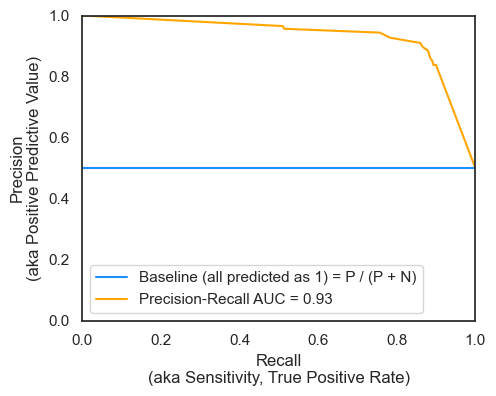

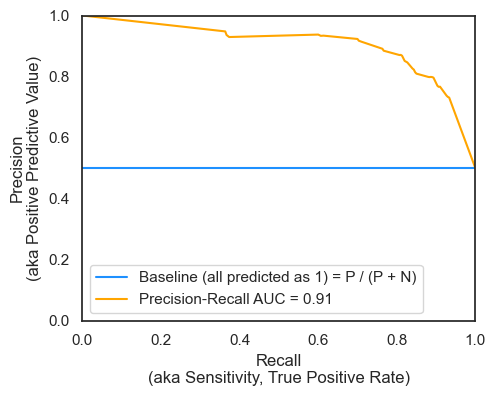

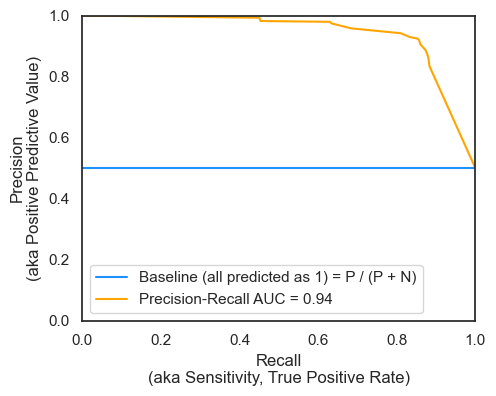

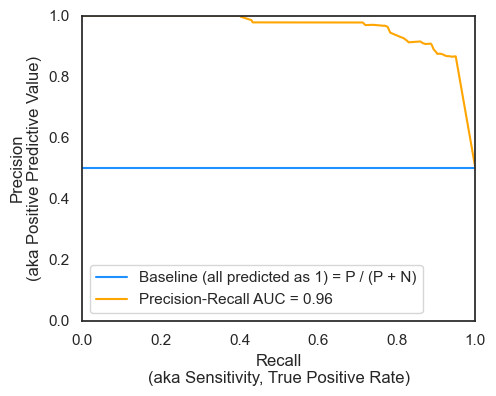

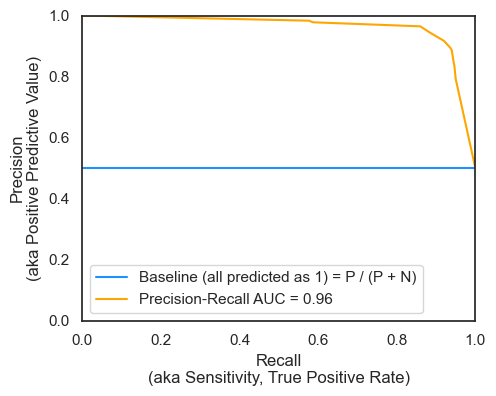

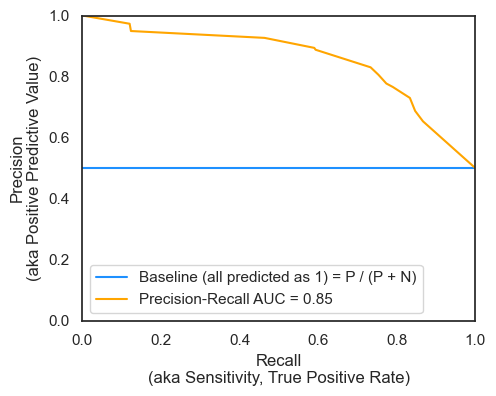

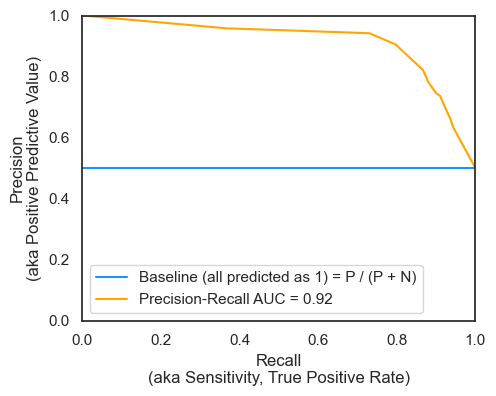

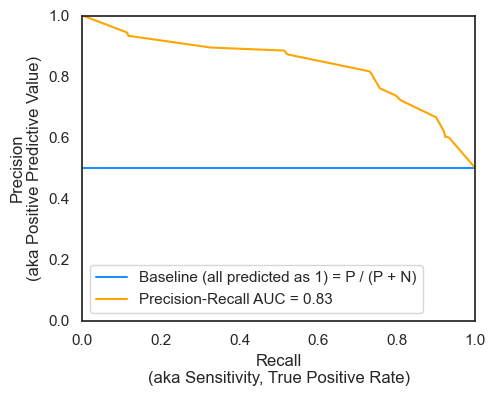

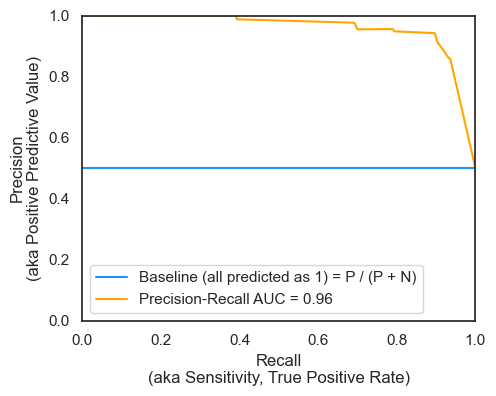

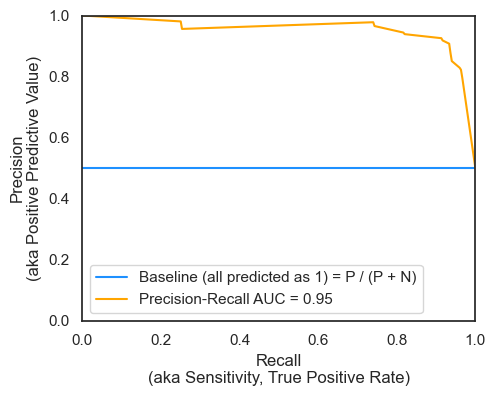

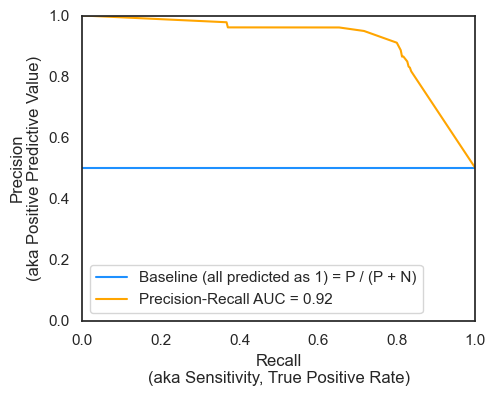

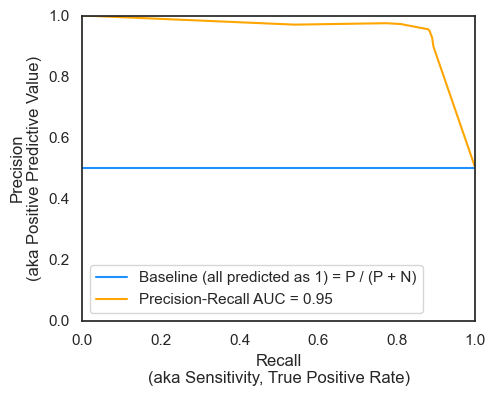

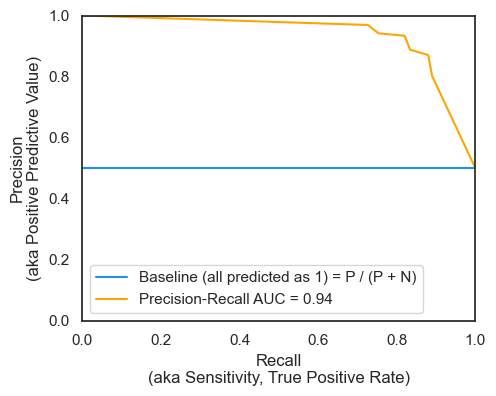

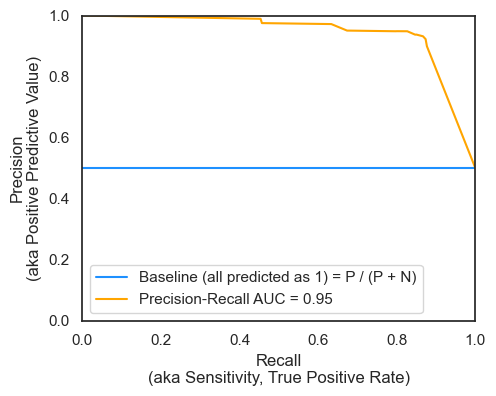

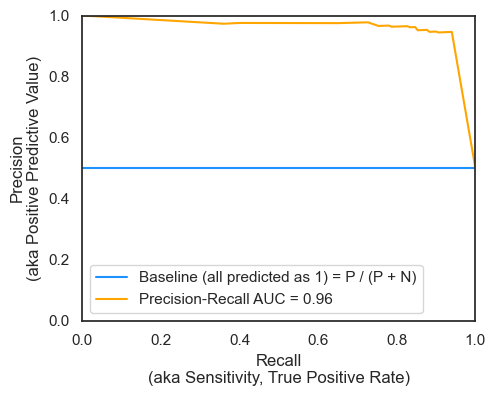

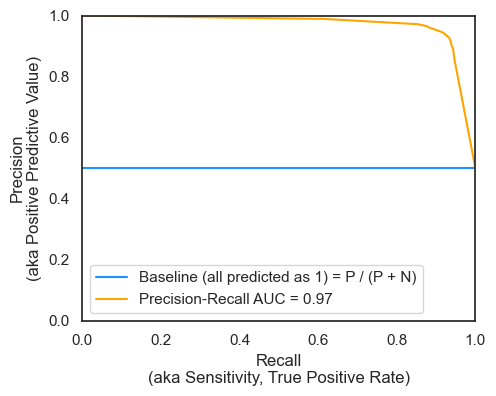

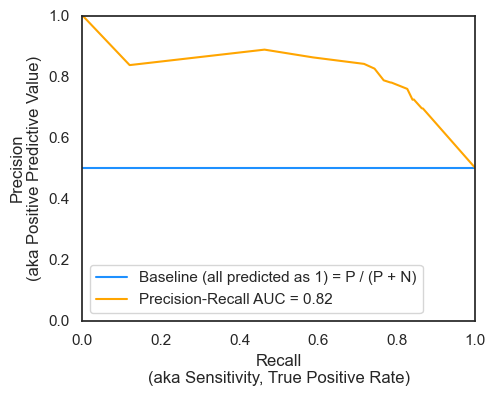

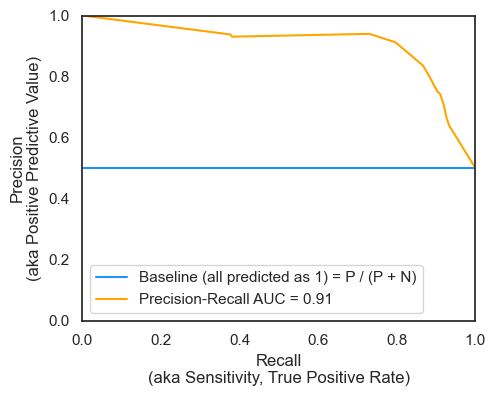

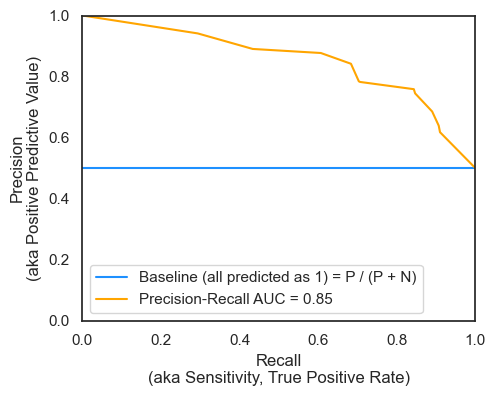

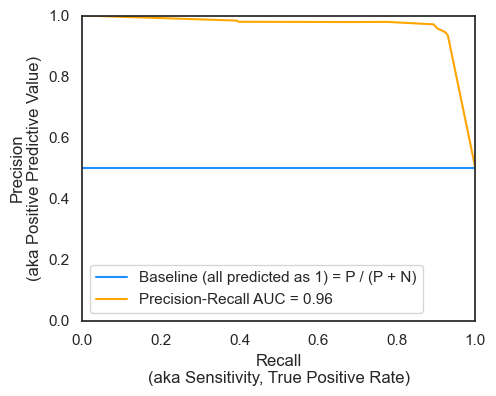

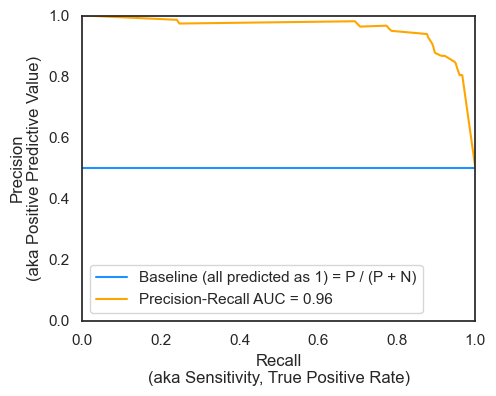

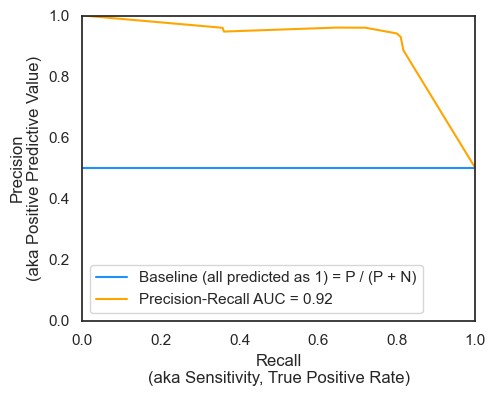

In [62]:
output_dir_i = './data/output/llms/'
os.makedirs(output_dir_i, exist_ok=True)

ts_i = datetime.datetime.utcnow().strftime('%y-%m-%dT%H-%M-%S')



potential_test_ids = feature_df_imputed['id'].values

from construct_tracker.machine_learning import metrics_report
# compute metrics for each model

for model in feature_df_imputed['model'].unique():

    results = []
    
    for col_name in prompt_names.values():
            feature_df_i = feature_df_imputed[feature_df_imputed['model'] == model]
        # try:
            construct = prompt_names_reverse[col_name]
            subreddit = construct_to_subreddit[construct]
            col_name = col_name.capitalize()
            # y_test = df[df['subreddit'] == subreddit]['dv_tag'].values
            # feature_df_i_construct = feature_df_i[feature_df_i[col_name+'_score'].notna()]
            # potential_test_ids = feature_df_i['id'].values
            
            test_i = create_binary_dataset(df, dv = subreddit, n_per_dv = 300, dv_location = 'subreddit', potential_test_ids = None)

            # print(test_i.shape[0])
            test_i['id'] = test_i['id'].astype(str)
            test_i = test_i.sort_values('id')

            test_ids = test_i['id']
            y_test = test_i['subreddit'].values
            
            y_test = [1 if n == subreddit else 0 for n in y_test]
            feature_df_i['id'] = feature_df_i['id'].astype(str)
            feature_df_i = feature_df_i.sort_values('id')
            feature_df_i = feature_df_i[feature_df_i['id'].isin(test_ids)]
            assert set(feature_df_i['id'].unique().tolist()) == set(test_ids)
            
            y_proba_1 = feature_df_i[col_name+'_score'].values
            y_pred = y_proba_1>=0.5*1
            # print(len(y_pred), len(y_test))
            assert len(y_pred) == len(y_test)
            construct_clean = construct.replace('_', ' ').capitalize()
            dv_clean = construct_clean
            output_filename = f"{model.replace('/', '-')}_{construct}"
            
            # feature_vector = model_clean

            custom_cr, sklearn_cr, cm_df_meaning, cm_df, cm_df_norm, y_pred_df = metrics_report.save_classification_performance(y_test, y_pred, y_proba_1, output_dir_i, 
                                                                                            output_filename=output_filename,feature_vector=None, model_name=model,best_params = None, classes = ['Other', f'{construct_clean}'],amount_of_clauses=None, save_output=True)
            results.append(custom_cr)
		
		    # results_content_validity.append(custom_cr_content_validity)

				
    results_df = pd.concat(results)
    results_df = results_df.reset_index(drop=True)
    model_clean_name = model.replace('/', '-')
    results_df.to_csv(output_dir_i + f'results_{model_clean_name}_{ts_i}.csv', index=False)

	# results_df_content_validity = pd.concat(results_content_validity)
	# results_df_content_validity = results_df_content_validity.reset_index(drop=True)
	# results_df_content_validity.to_csv(output_dir_i + f'results_content_validity_{n}_{ts_i}.csv', index=False)


    